In [1263]:
# Suppress warning messages to keep the output clean
import warnings
warnings.filterwarnings("ignore")

# Import essential libraries for data handling and analysis
import numpy as np                  # For numerical operations
import pandas as pd                # For working with dataframes and data manipulation
#import yfinance as yf              # For downloading historical market data

# Import technical analysis indicators from the 'ta' library
from ta.momentum import RSIIndicator           # Relative Strength Index for momentum analysis
from ta.trend import MACD                      # Moving Average Convergence Divergence for trend detection
from ta.volatility import BollingerBands       # Bollinger Bands for measuring price volatility
from ta.volatility import AverageTrueRange     # Average True Range for measuring market volatility
from ta.trend import SMAIndicator              # Simple Moving Average for trend smoothing


In [1264]:
from twelvedata import TDClient

td = "d6ccf0d1458441bda227ea6a01e2ac08"

In [1265]:
def fetch_forex_data(symbol: str, interval: str = "1day", outputsize: int = 5000, apikey: str = td) -> pd.DataFrame:
    try:
        # Initialize client
        td = TDClient(apikey=apikey)

        # Fetch data
        ts = td.time_series(
            symbol=symbol,
            interval=interval,
            outputsize=outputsize,
            timezone="UTC"
        ).as_pandas()

        if ts is None or ts.empty:
            raise ValueError(f"No data returned for symbol: {symbol}")

        # Reset index if needed
        ts = ts.rename_axis("Date").reset_index()

        # Ensure required columns are available
        required_cols = ['Date', 'open', 'high', 'low', 'close']
        missing = [col for col in required_cols if col not in ts.columns]
        if missing:
            raise KeyError(f"Missing expected columns: {missing}")

        # Clean and standardize column names
        df = ts[required_cols].copy()
        df.columns = ['Date', 'Open', 'High', 'Low', 'Close']
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)

        # Add dummy Volume column if needed
        df['Volume'] = 0

        return df

    except Exception as e:
        print(f"❌ Error fetching data for {symbol}: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

In [1266]:
df = fetch_forex_data("EUR/GBP", apikey=td)
if df.empty:
    print("Data fetch failed.")
else:
    print(df.head())


        Date    Open    High     Low   Close  Volume
0 2006-07-12  0.6919  0.6931  0.6893  0.6923       0
1 2006-07-13  0.6922  0.6931  0.6877  0.6883       0
2 2006-07-14  0.6883  0.6897  0.6870  0.6883       0
3 2006-07-17  0.6874  0.6896  0.6870  0.6883       0
4 2006-07-18  0.6879  0.6891  0.6834  0.6848       0


In [1267]:
# Downloading historical daily price data for the EUR/GBP currency pair from Yahoo Finance
#df = yf.download('EURUSD=X', interval='1d', period='30y', progress=False)

# Reset the DataFrame index to convert the 'Date' index into a regular column
#df.reset_index(inplace=True)


In [1268]:
# Checking if the downloaded DataFrame is empty (i.e., no data was returned)
if df.empty:
    raise ValueError("No data returned from Yahoo Finance. Try a shorter period or check your internet.")

In [1269]:
# PREPRPOCESSING

In [1270]:
# Cleaning columns and drop NaNs
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace=True)

In [1271]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2006-07-12,0.6919,0.6931,0.6893,0.6923,0
1,2006-07-13,0.6922,0.6931,0.6877,0.6883,0
2,2006-07-14,0.6883,0.6897,0.6870,0.6883,0
3,2006-07-17,0.6874,0.6896,0.6870,0.6883,0
4,2006-07-18,0.6879,0.6891,0.6834,0.6848,0


In [1272]:
# Extract and add new time-based features to the DataFrame
df['dayofweek'] = df['Date'].dt.dayofweek   # Day of the week (0=Monday, 6=Sunday)
df['month'] = df['Date'].dt.month           # Month of the year (1=January, 12=December)

In [1273]:
# Creating separate pandas Series for High, Low, and Close prices
# This makes it easier to pass them into technical indicator functions
high_series = pd.Series(df['High'].values.flatten(), index=df.index)
low_series = pd.Series(df['Low'].values.flatten(), index=df.index)
close_series = pd.Series(df['Close'].values.flatten(), index=df.index)

In [1274]:
# Calculateing the logarithmic return of the closing price
# This measures the percentage change in price on a logarithmic scale
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

In [1275]:
# === Technical Indicators Calculation ===

# Calculate 14-period Relative Strength Index (RSI) for momentum analysis
df['RSI'] = RSIIndicator(close=close_series, window=14).rsi()

# Calculate Moving Average Convergence Divergence (MACD) indicators
macd = MACD(close=close_series)
df['MACD'] = macd.macd()                      # MACD line
df['MACD_signal'] = macd.macd_signal()        # Signal line
df['MACD_diff'] = macd.macd_diff()            # MACD histogram (difference between MACD and Signal line)

# Calculate Bollinger Bands for volatility analysis
bb = BollingerBands(close=close_series)
df['BB_upper'] = bb.bollinger_hband()         # Upper Bollinger Band
df['BB_lower'] = bb.bollinger_lband()         # Lower Bollinger Band
df['BB_width'] = df['BB_upper'] - df['BB_lower']  # Band width as a volatility metric

# Calculate Simple Moving Averages (SMAs) for different periods
df['SMA_10'] = SMAIndicator(close=close_series, window=10).sma_indicator()
df['SMA_20'] = SMAIndicator(close=close_series, window=20).sma_indicator()
df['SMA_50'] = SMAIndicator(close=close_series, window=50).sma_indicator()
df['SMA_100'] = SMAIndicator(close=close_series, window=100).sma_indicator()

# Calculate Average True Range (ATR) to measure market volatility
atr = AverageTrueRange(high=high_series, low=low_series, close=close_series, window=14)
df['ATR'] = atr.average_true_range()


In [1276]:
print(type(df['Close']), df['Close'].shape)

<class 'pandas.core.series.Series'> (5000,)


In [1277]:
df.tail()

,Date,Open,High,Low,Close,Volume,dayofweek,month,Log_Return,RSI,...,MACD_signal,MACD_diff,BB_upper,BB_lower,BB_width,SMA_10,SMA_20,SMA_50,SMA_100,ATR
4995,2025-06-30,0.85462,0.85862,0.85393,0.85803,0,0,6,0.004427,67.978325,...,0.002548,0.000140,0.860324,0.843355,0.016969,0.854543,0.851839,0.846508,0.846723,0.003138
4996,2025-07-01,0.85810,0.85972,0.85568,0.85860,0,1,7,0.000664,68.862398,...,0.002615,0.000269,0.860467,0.844819,0.015648,0.855058,0.852643,0.846650,0.846931,0.003203
4997,2025-07-02,0.85860,0.86700,0.85770,0.86516,0,2,7,0.007611,76.800763,...,0.002798,0.000731,0.861942,0.845614,0.016329,0.855926,0.853778,0.846935,0.847191,0.003638
4998,2025-07-03,0.86495,0.86543,0.86058,0.86091,0,3,7,-0.004924,65.202795,...,0.002970,0.000685,0.862426,0.846623,0.015804,0.856359,0.854524,0.847156,0.847417,0.003725
4999,2025-07-04,0.86085,0.86375,0.86043,0.86344,0,4,7,0.002934,68.274253,...,0.003158,0.000755,0.863474,0.847145,0.016330,0.857121,0.855309,0.847424,0.847639,0.003696


In [1278]:
# Flatten column names in case any are multi-index tuples (e.g., from groupby or merge operations)
# This ensures all column names are simple strings
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

In [1279]:
# Checking for missing (NaN) values in each column and display the total count per column
missing = df.isnull().sum()
missing

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
dayofweek       0
month           0
Log_Return      1
RSI            13
MACD           25
MACD_signal    33
MACD_diff      33
BB_upper       19
BB_lower       19
BB_width       19
SMA_10          9
SMA_20         19
SMA_50         49
SMA_100        99
ATR             0
dtype: int64

In [1280]:
# Remove rows with incomplete indicator values
df.dropna(inplace=True)

In [1281]:
df.head()

,Date,Open,High,Low,Close,Volume,dayofweek,month,Log_Return,RSI,...,MACD_signal,MACD_diff,BB_upper,BB_lower,BB_width,SMA_10,SMA_20,SMA_50,SMA_100,ATR
99,2006-11-28,0.6777,0.6780,0.6746,0.6761,0,1,11,-0.002659,54.910659,...,0.000986,0.000309,0.680685,0.667255,0.013430,0.67683,0.673970,0.673206,0.676073,0.003029
100,2006-11-29,0.6760,0.6765,0.6732,0.6758,0,2,11,-0.000444,53.931093,...,0.001029,0.000169,0.680572,0.668118,0.012453,0.67651,0.674345,0.673282,0.675908,0.003049
101,2006-11-30,0.6757,0.6763,0.6729,0.6738,0,3,11,-0.002964,47.807998,...,0.001013,-0.000064,0.680387,0.668733,0.011653,0.67613,0.674560,0.673318,0.675763,0.003074
102,2006-12-01,0.6733,0.6742,0.6715,0.6736,0,4,12,-0.000297,47.230515,...,0.000955,-0.000229,0.680057,0.669523,0.010534,0.67582,0.674790,0.673336,0.675616,0.003047
103,2006-12-04,0.6745,0.6747,0.6717,0.6731,0,0,12,-0.000743,45.742911,...,0.000865,-0.000361,0.679863,0.669987,0.009876,0.67558,0.674925,0.673376,0.675464,0.003044


In [1282]:
# EXPLOITATIVE DATA ANALYSIS

In [1283]:
df.describe()

,Date,Open,High,Low,Close,Volume,dayofweek,month,Log_Return,RSI,...,MACD_signal,MACD_diff,BB_upper,BB_lower,BB_width,SMA_10,SMA_20,SMA_50,SMA_100,ATR
count,4901,4901.000000,4901.000000,4901.000000,4901.000000,4901.0,4901.000000,4901.000000,4901.000000,4901.000000,...,4901.000000,4901.000000,4901.000000,4901.000000,4901.000000,4901.000000,4901.000000,4901.000000,4901.000000,4901.000000
mean,2016-04-16 08:01:16.392572928,0.836336,0.839819,0.833194,0.836420,0.0,2.029178,6.456846,0.000049,50.014899,...,0.000252,0.000002,0.848695,0.823441,0.025254,0.836252,0.836068,0.835533,0.834652,0.006643
min,2006-11-28 00:00:00,0.655100,0.657300,0.653400,0.655200,0.0,0.000000,1.000000,-0.031688,18.199950,...,-0.009344,-0.011458,0.663388,0.649336,0.003399,0.657560,0.659150,0.666296,0.669750,0.002192
25%,2011-08-09 00:00:00,0.813800,0.816400,0.811200,0.813800,0.0,1.000000,3.000000,-0.002651,42.039032,...,-0.002117,-0.000725,0.824025,0.800539,0.015451,0.812860,0.813135,0.810978,0.813190,0.004911
50%,2016-04-19 00:00:00,0.852700,0.855500,0.849850,0.852600,0.0,2.000000,6.000000,-0.000035,49.401051,...,-0.000274,-0.000011,0.862642,0.839628,0.021278,0.852590,0.852160,0.853260,0.853693,0.006302
75%,2020-12-29 00:00:00,0.875600,0.879350,0.871900,0.875500,0.0,3.000000,9.000000,0.002627,57.375925,...,0.002189,0.000736,0.888595,0.862067,0.030109,0.875780,0.876425,0.876060,0.875422,0.007906
max,2025-07-04 00:00:00,0.975800,0.980500,0.965200,0.974700,0.0,5.000000,12.000000,0.059840,87.552201,...,0.029232,0.007074,0.995309,0.907385,0.154473,0.956110,0.934970,0.915374,0.910732,0.020018
std,NaN,0.058878,0.059258,0.058499,0.058744,0.0,1.437460,3.463987,0.005012,11.092101,...,0.004099,0.001403,0.060593,0.057893,0.016545,0.058688,0.058678,0.058737,0.058899,0.002653


In [1284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4901 entries, 99 to 4999
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         4901 non-null   datetime64[ns]
 1   Open         4901 non-null   float64       
 2   High         4901 non-null   float64       
 3   Low          4901 non-null   float64       
 4   Close        4901 non-null   float64       
 5   Volume       4901 non-null   int64         
 6   dayofweek    4901 non-null   int32         
 7   month        4901 non-null   int32         
 8   Log_Return   4901 non-null   float64       
 9   RSI          4901 non-null   float64       
 10  MACD         4901 non-null   float64       
 11  MACD_signal  4901 non-null   float64       
 12  MACD_diff    4901 non-null   float64       
 13  BB_upper     4901 non-null   float64       
 14  BB_lower     4901 non-null   float64       
 15  BB_width     4901 non-null   float64       
 16  SMA_10    

In [1285]:
# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Defining a function to plot MACD and RSI indicators for the DataFrame
def plot_macd_rsi(df, title="Indicators"):
    # Create a figure with two subplots: one for MACD, one for RSI
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # === MACD Plot ===
    ax1.plot(df['Date'], df['MACD'], label='MACD', color='blue')              # Plot MACD line
    ax1.plot(df['Date'], df['MACD_signal'], label='Signal', color='orange')   # Plot Signal line
    ax1.bar(df['Date'], df['MACD_diff'], label='MACD Diff', color='gray', alpha=0.5)  # Plot MACD histogram
    ax1.set_title(f"{title} - MACD")
    ax1.legend()
    ax1.grid(True)

    # === RSI Plot ===
    ax2.plot(df['Date'], df['RSI'], label='RSI', color='green')               # Plot RSI line
    ax2.axhline(70, color='red', linestyle='--', label='Overbought')          # Overbought threshold
    ax2.axhline(30, color='blue', linestyle='--', label='Oversold')           # Oversold threshold
    ax2.set_title(f"{title} - RSI")
    ax2.set_ylim(0, 100)
    ax2.legend()
    ax2.grid(True)

    # Optimize layout and display the plot
    plt.tight_layout()
    plt.show()

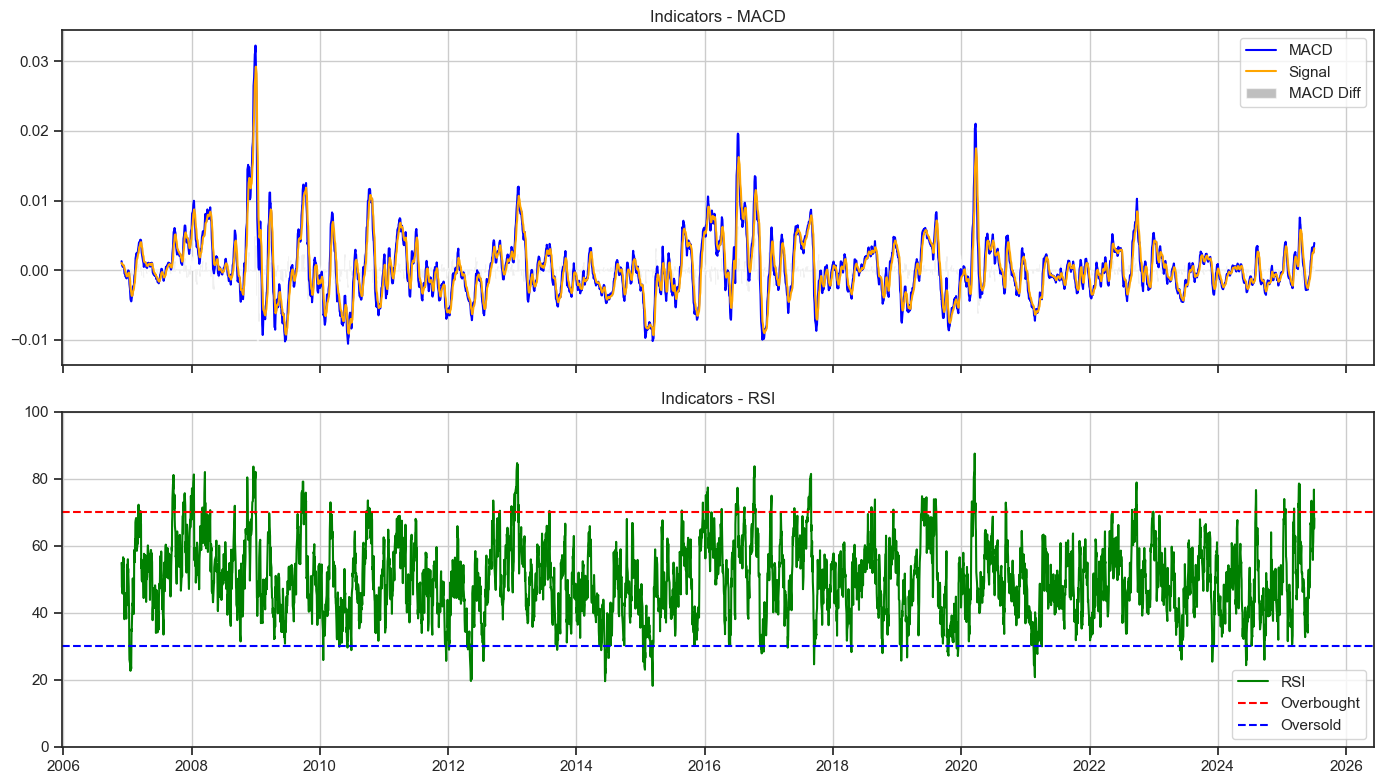

In [1286]:
plot_macd_rsi(df)

In [1287]:
# Import date formatting tools for better x-axis handling in plots
import matplotlib.dates as mdates

# Define a function to plot Close Price with Bollinger Bands, MACD, and formatted x-axis
def plot_bb_macd_chart(df, title="Technical Analysis"):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' is in datetime format for plotting

    # Set up a 3-row subplot layout with custom height ratios
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 1, height_ratios=[3, 1.5, 1], hspace=0.3)

    # === 1. Close Price with Bollinger Bands ===
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(df['Date'], df['Close'], label='Close Price', color='black')            # Plot closing price
    ax0.plot(df['Date'], df['BB_upper'], label='BB Upper', color='red', linestyle='--')  # Upper Bollinger Band
    ax0.plot(df['Date'], df['BB_lower'], label='BB Lower', color='blue', linestyle='--') # Lower Bollinger Band
    ax0.fill_between(df['Date'], df['BB_upper'], df['BB_lower'], color='gray', alpha=0.1) # Shaded BB area
    ax0.set_title(f"{title} - Price & Bollinger Bands")
    ax0.legend()
    ax0.grid(True)

    # === 2. MACD Plot ===
    ax1 = fig.add_subplot(gs[1])
    ax1.plot(df['Date'], df['MACD'], label='MACD', color='blue')               # MACD line
    ax1.plot(df['Date'], df['MACD_signal'], label='Signal', color='orange')    # Signal line
    ax1.bar(df['Date'], df['MACD_diff'], label='MACD Diff', color='gray', alpha=0.5)  # MACD histogram
    ax1.set_title("MACD")
    ax1.legend()
    ax1.grid(True)

    # === 3. Shared X-axis Formatting ===
    # Format the x-axis of upper plots with months for better readability
    for ax in [ax0, ax1]:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))                   # Set major ticks every 2 months
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))                   # Format as "Month Year"

    # Optimize layout and display the complete figure
    plt.tight_layout()
    plt.show()

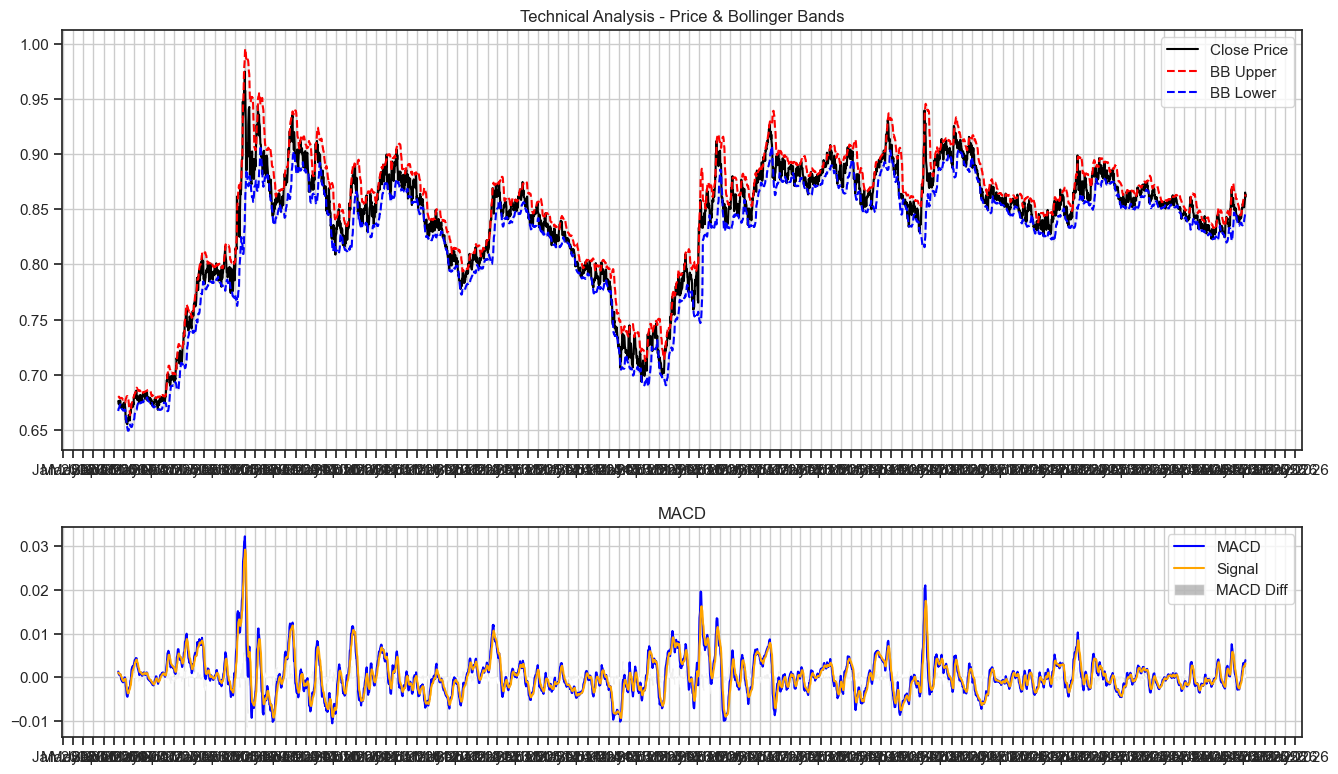

In [1288]:
plot_bb_macd_chart(df)

In [1289]:
# Display the list of all column names in the DataFrame
df.columns.tolist()

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'dayofweek',
 'month',
 'Log_Return',
 'RSI',
 'MACD',
 'MACD_signal',
 'MACD_diff',
 'BB_upper',
 'BB_lower',
 'BB_width',
 'SMA_10',
 'SMA_20',
 'SMA_50',
 'SMA_100',
 'ATR']

In [1290]:
# Create a new DataFrame `comp` by dropping non-essential or categorical columns 
# such as 'dayofweek', 'month', and 'Volume' if they exist
comp = df.drop(columns=["dayofweek", "month", "Volume"], errors='ignore')

In [1291]:
# Import seaborn for enhanced visualizations
import seaborn as sns

# Defining a function to plot a heatmap of correlations between numerical features
def plot_correlation_heatmap(comp):
    plt.figure(figsize=(10, 6))  # Set the figure size
    sns.heatmap(
        comp.corr(numeric_only=True),  # Compute correlation matrix of numeric columns
        annot=True,                    # Display correlation values in the heatmap
        cmap='coolwarm',               # Use a diverging colormap for clarity
        center=0                       # Center the colormap at 0 for balanced visual
    )
    plt.title("Correlation Heatmap of Technical Indicators")
    plt.show()

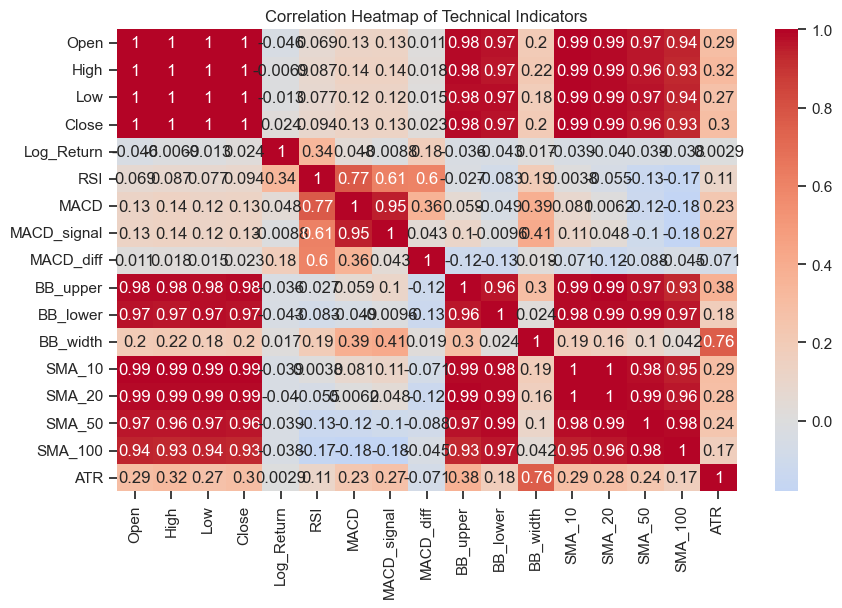

In [1292]:
# Call the function to display the correlation heatmap for the technical indicators in 'comp'
plot_correlation_heatmap(comp)

In [1293]:
# Define a function to visualize the price trend along with SMAs and Bollinger Bands
def plot_price_trend(df, title="Price & Trend"):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' is in datetime format

    # === Plot Price and Trend Indicators ===
    plt.figure(figsize=(16, 8))
    plt.plot(df['Date'], df['Close'], label='Close Price', color='black', linewidth=1.5)        # Closing price
    plt.plot(df['Date'], df['SMA_20'], label='SMA 20', color='blue', linestyle='--')            # 20-day SMA
    plt.plot(df['Date'], df['SMA_50'], label='SMA 50', color='green', linestyle='--')           # 50-day SMA
    plt.plot(df['Date'], df['SMA_100'], label='SMA 100', color='yellow', linestyle='--')        # 100-day SMA
    plt.plot(df['Date'], df['BB_upper'], label='BB Upper', color='red', linestyle=':')          # Upper Bollinger Band
    plt.plot(df['Date'], df['BB_lower'], label='BB Lower', color='purple', linestyle=':')       # Lower Bollinger Band
    plt.fill_between(df['Date'], df['BB_upper'], df['BB_lower'], color='gray', alpha=0.1)       # Shaded BB region

    # === Customize Plot Aesthetics ===
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()

    # Format x-axis with month-year ticks every 2 months
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

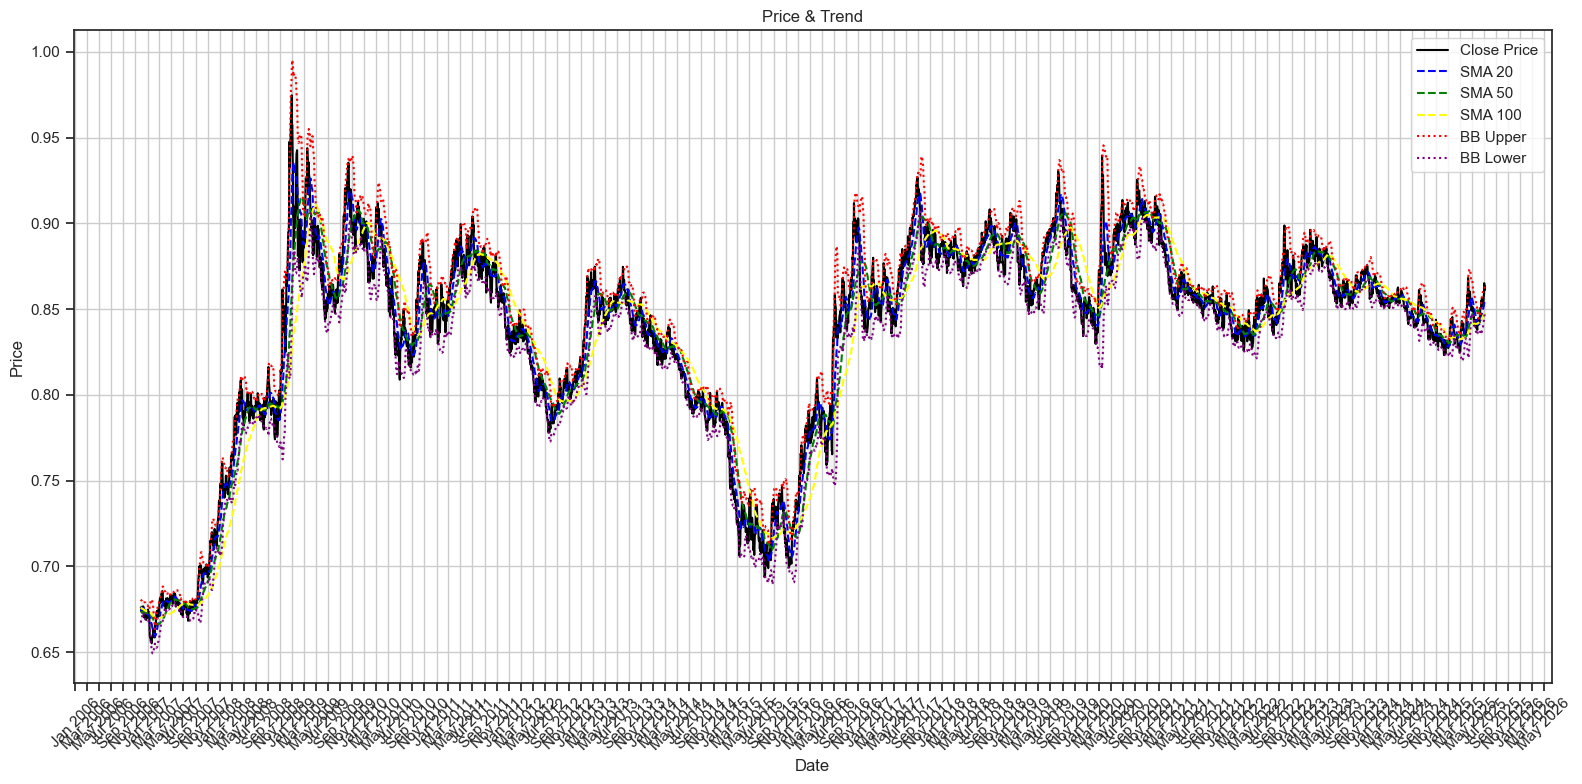

In [1294]:
plot_price_trend(df)

In [1295]:
# Define a function to plot a scatter matrix (pair plot) for selected technical indicators
def plot_scatter_matrix(df, indicators=None, title="Indicator Pair Plot"):
    # Set default indicators to plot if none are specified
    if indicators is None:
        indicators = ['Close', 'RSI', 'MACD', 'MACD_signal', 'BB_width']

    # Select specified columns and drop rows with missing values
    data = df[indicators].dropna()

    # Plot pairwise relationships with KDE on diagonals and scatter plots on lower triangle
    sns.set(style="ticks", color_codes=True)
    sns.pairplot(data, diag_kind="kde", corner=True)
    plt.suptitle(title, y=1.02)  # Set the main title above the plot
    plt.show()

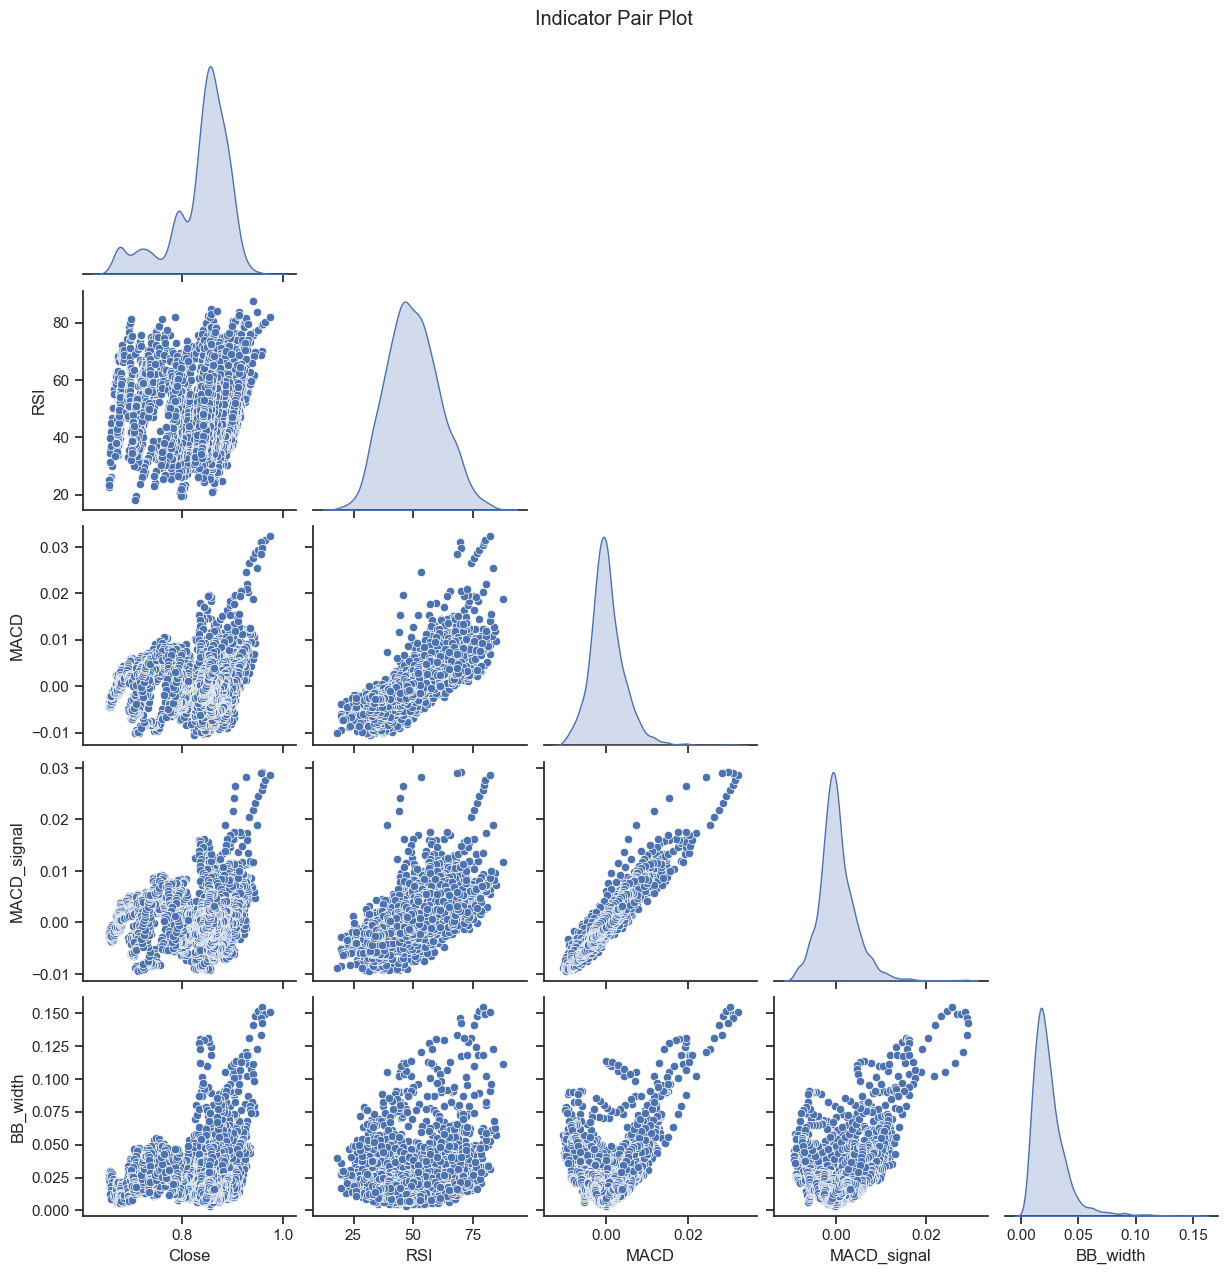

In [1296]:
plot_scatter_matrix(df)

In [1297]:
# FEATURE ENGINEERING

In [1298]:
# === Lag Features ===
# Create lagged versions of the 'Close' price to capture historical price behavior as features
df['lag_1'] = df['Close'].shift(1)  # Close price from 1 day ago
df['lag_2'] = df['Close'].shift(2)  # Close price from 2 days ago
df['lag_3'] = df['Close'].shift(3)  # Close price from 3 days ago

In [1299]:
# === Return Features ===
# Calculate the 1-day percentage return of the closing price
df['return_1d'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)) * 100

In [1300]:
# === Rolling Statistics ===
# Compute rolling statistics to capture short- and medium-term trends and volatility

df['sma_5'] = df['Close'].rolling(5).mean()        # 5-day simple moving average
df['sma_10'] = df['Close'].rolling(10).mean()      # 10-day simple moving average
df['sma_21'] = df['Close'].rolling(21).mean()      # 21-day simple moving average (approx. 1 trading month)

df['volatility_10'] = df['Close'].rolling(10).std()  # 10-day rolling standard deviation (volatility)
df['volatility_21'] = df['Close'].rolling(21).std()  # 21-day rolling standard deviation (volatility)

In [1301]:
# === Price Action Features ===

# Extract series for OHLC prices
high_series = df['High'].squeeze()
low_series = df['Low'].squeeze()
open_series = df['Open'].squeeze()
close_series = df['Close'].squeeze()

# Compute the larger value between Open and Close for each row (top of the real body)
high_body_max = pd.concat([open_series, close_series], axis=1).max(axis=1)

# Compute the smaller value between Open and Close for each row (bottom of the real body)
low_body_min = pd.concat([open_series, close_series], axis=1).min(axis=1)

# Calculate upper shadow: difference between the High and the top of the candle body
df['upper_shadow'] = high_series - high_body_max

# Calculate lower shadow: difference between the bottom of the candle body and the Low
df['lower_shadow'] = low_body_min - low_series

In [1302]:
# === Temporal Features ===
# Extract time-based features from the 'Date' column

df['dayofweek'] = df['Date'].dt.dayofweek              # Day of the week (0 = Monday, ..., 6 = Sunday)
df['month'] = df['Date'].dt.month                      # Month of the year (1 = January, ..., 12 = December)

# Flags to identify start and end of the trading week
df['is_week_start'] = (df['dayofweek'] == 0).astype(int)  # 1 if Monday, else 0
df['is_week_end'] = (df['dayofweek'] == 4).astype(int)    # 1 if Friday, else 0

In [1303]:
# === Targets ===
# Define target variables for supervised learning tasks

df['target_regression'] = df['Close'].shift(-1)                   # Next day's closing price (for regression)
df['target_classification'] = (df['Close'].shift(-1) > df['Close']).astype(int)  # 1 if price goes up next day, else 0 (for classification)

In [1304]:
# Remove any remaining rows with missing values to ensure model compatibility
df.dropna(inplace=True)

# Reset the DataFrame index after dropping rows to maintain a clean, continuous index
df.reset_index(drop=True, inplace=True)

In [1305]:
df.head()

,Date,Open,High,Low,Close,Volume,dayofweek,month,Log_Return,RSI,...,sma_10,sma_21,volatility_10,volatility_21,upper_shadow,lower_shadow,is_week_start,is_week_end,target_regression,target_classification
0,2006-12-26,0.6687,0.6716,0.6687,0.6703,0,1,12,0.002240,43.253265,...,0.67075,0.673024,0.001061,0.002504,0.0013,0.0000,0,0,0.6704,1
1,2006-12-27,0.6702,0.6718,0.6700,0.6704,0,2,12,0.000149,43.580477,...,0.67061,0.672752,0.000997,0.002463,0.0014,0.0002,0,0,0.6699,0
2,2006-12-28,0.6704,0.6718,0.6691,0.6699,0,3,12,-0.000746,42.268107,...,0.67057,0.672471,0.001019,0.002434,0.0014,0.0008,0,0,0.6740,1
3,2006-12-29,0.6697,0.6744,0.6694,0.6740,0,4,12,0.006102,54.395568,...,0.67092,0.672481,0.001486,0.002440,0.0004,0.0003,0,1,0.6739,0
4,2007-01-01,0.6735,0.6741,0.6723,0.6739,0,0,1,-0.000148,54.097079,...,0.67106,0.672495,0.001702,0.002448,0.0002,0.0012,1,0,0.6727,0


In [1306]:
# Calculate the absolute size of the candlestick body (difference between Close and Open)
df['body'] = (df['Close'] - df['Open']).abs()

# Display the first 5 values of the 'body' column
df['body'].head()

0    0.0016
1    0.0002
2    0.0005
3    0.0043
4    0.0004
Name: body, dtype: float64

In [1307]:
df['body'].describe()

count    4880.000000
mean        0.003017
std         0.002978
min         0.000000
25%         0.000990
50%         0.002200
75%         0.004103
max         0.047100
Name: body, dtype: float64

In [1308]:
# === Candle Attributes ===

# Calculate the full candlestick range (high - low) for each day
df['range'] = df['High'] - df['Low']

# Determine the top and bottom of the candlestick body
high_body_max = df[['Open', 'Close']].max(axis=1)  # Upper edge of the candle body
low_body_min = df[['Open', 'Close']].min(axis=1)   # Lower edge of the candle body

# Calculate the size of the upper shadow (wick above the body)
df['upper_shadow'] = df['High'].astype(float) - high_body_max.astype(float)

# Calculate the size of the lower shadow (wick below the body)
df['lower_shadow'] = low_body_min - df['Low']

In [1309]:
# === Candlestick Flags ===
# Identify specific candlestick patterns based on body and shadow proportions

# Doji: very small body relative to total range (indecision in the market)
df['is_doji'] = (df['body'] / df['range'] < 0.1).astype(int)

# Hammer: small body with long lower shadow and tiny upper shadow (potential bullish reversal)
df['is_hammer'] = ((df['lower_shadow'] > 2 * df['body']) & 
                   (df['upper_shadow'] < 0.1 * df['body'])).astype(int)

# Inverted Hammer: small body with long upper shadow and tiny lower shadow (potential bullish reversal in downtrend)
df['is_inverted_hammer'] = ((df['upper_shadow'] > 2 * df['body']) & 
                            (df['lower_shadow'] < 0.1 * df['body'])).astype(int)

In [1310]:
# === Engulfing Patterns ===
# Store previous day's open and close prices to detect bullish and bearish engulfing patterns

df['prev_close'] = df['Close'].shift(1)  # Previous day's closing price
df['prev_open'] = df['Open'].shift(1)    # Previous day's opening price

In [1311]:
# Detect classic candlestick engulfing patterns for potential trend reversals

# Bullish Engulfing:
# Previous candle is bearish (close < open), current is bullish (close > open),
# and current body completely engulfs the previous body
df['is_bullish_engulfing'] = (
    (df['prev_close'] > df['prev_open']) &          # Previous candle is bearish
    (df['Close'] > df['Open']) &                    # Current candle is bullish
    (df['Open'] < df['prev_close']) &               # Current open is lower than previous close
    (df['Close'] > df['prev_open'])                 # Current close is higher than previous open
).astype(int)

# Bearish Engulfing:
# Previous candle is bullish, current is bearish, and current body engulfs previous
df['is_bearish_engulfing'] = (
    (df['prev_open'] > df['prev_close']) &          # Previous candle is bullish
    (df['Close'] < df['Open']) &                    # Current candle is bearish
    (df['Open'] > df['prev_close']) &               # Current open is higher than previous close
    (df['Close'] < df['prev_open'])                 # Current close is lower than previous open
).astype(int)

In [1312]:
# === Trend Indicators ===
# Create binary features to capture trend direction and momentum

df['price_above_sma20'] = (df['Close'] > df['SMA_20']).astype(int)     # 1 if price is above 20-day SMA else 0
df['price_above_sma50'] = (df['Close'] > df['SMA_50']).astype(int)     # 1 if price is above 50-day SMA else 0
df['sma_crossover'] = (df['SMA_20'] > df['SMA_50']).astype(int)        # 1 if short-term SMA crosses above long-term SMA else 0
df['log_return_positive'] = (df['Log_Return'] > 0).astype(int)         # 1 if log return is positive (price increased) else 0

In [1313]:
# Drop temporary columns used for engulfing pattern detection to clean up the DataFrame
df.drop(columns=['prev_open', 'prev_close'], inplace=True)

In [1314]:
df.head()

,Date,Open,High,Low,Close,Volume,dayofweek,month,Log_Return,RSI,...,range,is_doji,is_hammer,is_inverted_hammer,is_bullish_engulfing,is_bearish_engulfing,price_above_sma20,price_above_sma50,sma_crossover,log_return_positive
0,2006-12-26,0.6687,0.6716,0.6687,0.6703,0,1,12,0.002240,43.253265,...,0.0029,0,0,0,0,0,0,0,1,1
1,2006-12-27,0.6702,0.6718,0.6700,0.6704,0,2,12,0.000149,43.580477,...,0.0018,0,0,0,1,0,0,0,0,1
2,2006-12-28,0.6704,0.6718,0.6691,0.6699,0,3,12,-0.000746,42.268107,...,0.0027,0,0,0,0,0,0,0,0,0
3,2006-12-29,0.6697,0.6744,0.6694,0.6740,0,4,12,0.006102,54.395568,...,0.0050,0,0,0,0,0,1,1,0,1
4,2007-01-01,0.6735,0.6741,0.6723,0.6739,0,0,1,-0.000148,54.097079,...,0.0018,0,0,0,1,0,1,1,0,0


In [1315]:
from datetime import timedelta

# Remove timezone awareness
today = pd.Timestamp.utcnow().replace(tzinfo=None).normalize()
two_weeks_ago = today - timedelta(days=14)

# Ensure Date column is also tz-naive
df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)

# Filter
df_train = df[df['Date'] < two_weeks_ago].reset_index(drop=True)
df_last_2weeks = df[df['Date'] >= two_weeks_ago].reset_index(drop=True)

In [1316]:
df_last_2weeks.shape

(12, 47)

In [1317]:
# MODEL TRAINING

In [1318]:
# Import train_test_split to divide the dataset into training and testing sets
from sklearn.model_selection import train_test_split

In [1319]:
# Define the target variable for regression and select input features
target = 'target_regression'

# Exclude non-feature columns such as Date and target labels from the feature set
features = df_train.drop(columns=['Date', 'target_regression', 'target_classification'])

In [1320]:
# Assign features and target to X and y for model training
X = features          # Feature matrix
y = df_train[target]        # Target variable (next day's closing price)

In [1321]:
X.columns.tolist()

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'dayofweek',
 'month',
 'Log_Return',
 'RSI',
 'MACD',
 'MACD_signal',
 'MACD_diff',
 'BB_upper',
 'BB_lower',
 'BB_width',
 'SMA_10',
 'SMA_20',
 'SMA_50',
 'SMA_100',
 'ATR',
 'lag_1',
 'lag_2',
 'lag_3',
 'return_1d',
 'sma_5',
 'sma_10',
 'sma_21',
 'volatility_10',
 'volatility_21',
 'upper_shadow',
 'lower_shadow',
 'is_week_start',
 'is_week_end',
 'body',
 'range',
 'is_doji',
 'is_hammer',
 'is_inverted_hammer',
 'is_bullish_engulfing',
 'is_bearish_engulfing',
 'price_above_sma20',
 'price_above_sma50',
 'sma_crossover',
 'log_return_positive']

In [1322]:
# === Train-test split ===
# Split the dataset into training and testing sets (80% train, 20% test)
# shuffle=False ensures chronological order is preserved (important for time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [1323]:
# Display the shape of the training feature set (rows, columns)
X_train.shape

(3894, 44)

In [1324]:
# Import the Prophet library for time series forecasting
from prophet import Prophet

In [1325]:
# Import Augmented Dickey-Fuller test from statsmodels to check for stationarity
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on the 'Close' price series
adf_test = adfuller(df_train['Close'])

# Organize and display the ADF test results
adf_results = {
    "Test Statistic": adf_test[0],                   # The test statistic value
    "p-value": adf_test[1],                          # p-value to assess stationarity
    "Lags Used": adf_test[2],                        # Number of lags used in the test
    "Number of Observations Used": adf_test[3],      # Number of observations included
    "Critical Values": adf_test[4],                  # Critical values at 1%, 5%, and 10% confidence levels
}

# Print results in a readable format
for key, value in adf_results.items():
    print(f"{key}: {value}")

Test Statistic: -3.361579833834598
p-value: 0.012340454284840372
Lags Used: 2
Number of Observations Used: 4865
Critical Values: {'1%': -3.4316948620176393, '5%': -2.862134279956787, '10%': -2.5670863365651626}


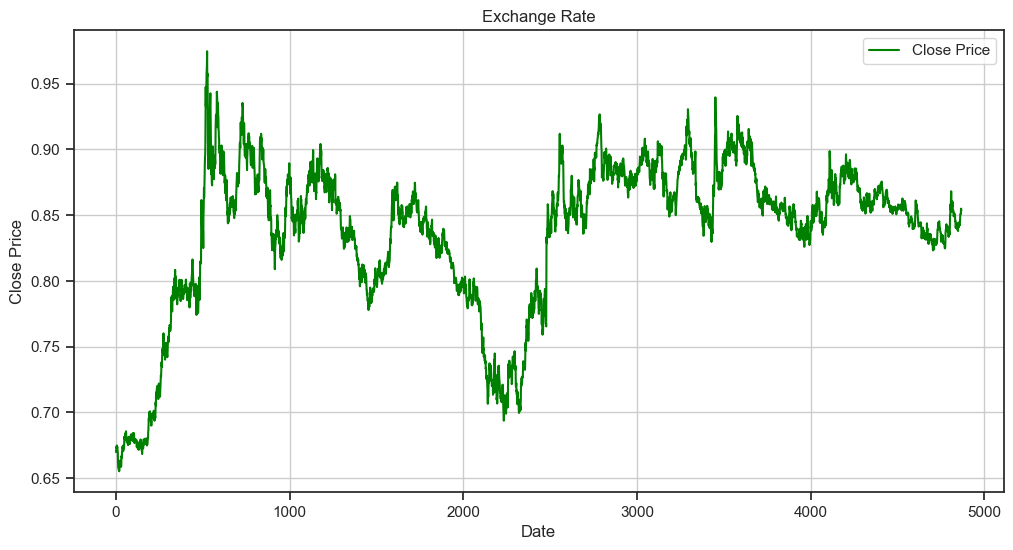

In [1326]:
# Plot the differenced 'Close' price to visualize stationarity

plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train['Close'], label='Close Price', color='green')  # Plot differenced close prices
plt.title("Exchange Rate")                                       # Chart title
plt.xlabel("Date")                                                       # X-axis label
plt.ylabel("Close Price")                                                # Y-axis label
plt.legend()
plt.grid()
plt.show()

In [1327]:
# === Model Evaluation Metrics ===

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define a function to evaluate and print regression performance metrics
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)             # Mean Absolute Error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))    # Root Mean Squared Error
    r2 = r2_score(y_true, y_pred)                          # R-squared score

    # Display evaluation results
    print(f"{name} Evaluation:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")
    print()

In [1328]:
usable_regressors = [
    'Log_Return', 'RSI', 'MACD', 'upper_shadow',
    'lower_shadow'
]

In [1329]:
"""usable_regressors = [
    'Log_Return', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff',
    'BB_width', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100',
    'ATR', 'return_1d', 'sma_5', 'sma_10', 'sma_21',
    'volatility_10', 'volatility_21', 'upper_shadow',
    'lower_shadow', 'body', 'range'
]"""

"usable_regressors = [\n    'Log_Return', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff',\n    'BB_width', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100',\n    'ATR', 'return_1d', 'sma_5', 'sma_10', 'sma_21',\n    'volatility_10', 'volatility_21', 'upper_shadow',\n    'lower_shadow', 'body', 'range'\n]"

In [1330]:
# Initialize and fit the Prophet model for forecasting

# Prepare the DataFrame in Prophet's expected format:
# 'ds' for datetime column and 'y' for the target variable
# Prepare input for Prophet
# Prepare input DataFrame for Prophet
prophet_df = df_train[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Add all available usable regressors
for reg in usable_regressors:
    if reg in df_train.columns:
        prophet_df[reg] = df_train[reg]

# Initialize the Prophet model with daily seasonality enabled
prophet = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.2,      # Higher = more flexible trend shifts
    seasonality_prior_scale=10.0      # Higher = more seasonal variation
)

prophet.add_seasonality(name='monthly', period=30.5, fourier_order=8)

# Register the regressors with the model
for reg in usable_regressors:
    if reg in prophet_df.columns:
        prophet.add_regressor(reg)
    
# Fit the Prophet model to the data
prophet.fit(prophet_df)

16:56:56 - cmdstanpy - INFO - Chain [1] start processing
16:57:11 - cmdstanpy - INFO - Chain [1] done processing


In [1331]:
# === Make Forecast with Prophet using All Usable Regressors ===

# Create a future dataframe that extends the timeline by the length of the test set
future = prophet.make_future_dataframe(periods=len(X_test), freq='D')

# Pad future regressors
for reg in usable_regressors:
    if reg in df_train.columns:
        recent_val = df_train[reg].dropna().values[-1]
        reg_full = np.concatenate([
            df_train[reg].dropna().values[-(len(future) - len(X_test)):],
            [recent_val] * len(X_test)
        ])
        future[reg] = reg_full[-len(future):]

# Generate forecast for both historical and future dates
forecast = prophet.predict(future)

# Extract predicted values for test period
prophet_preds = forecast['yhat'].iloc[-len(X_test):].values

In [1332]:
# === Prepare Comparison DataFrame ===

# Extract the actual closing prices for the test period
actual = df_train['Close'].iloc[-len(X_test):].reset_index(drop=True)

# Create a DataFrame to compare actual vs. Prophet-predicted values
prophet_df = pd.DataFrame({
    'Date': df_train['Date'].iloc[-len(X_test):].values,     # Corresponding dates
    'Actual_Close': df_train['Close'].iloc[-len(X_test):].values,                            # Actual close prices
    'Prophet_Predicted': prophet_preds                 # Predicted close prices by Prophet
})

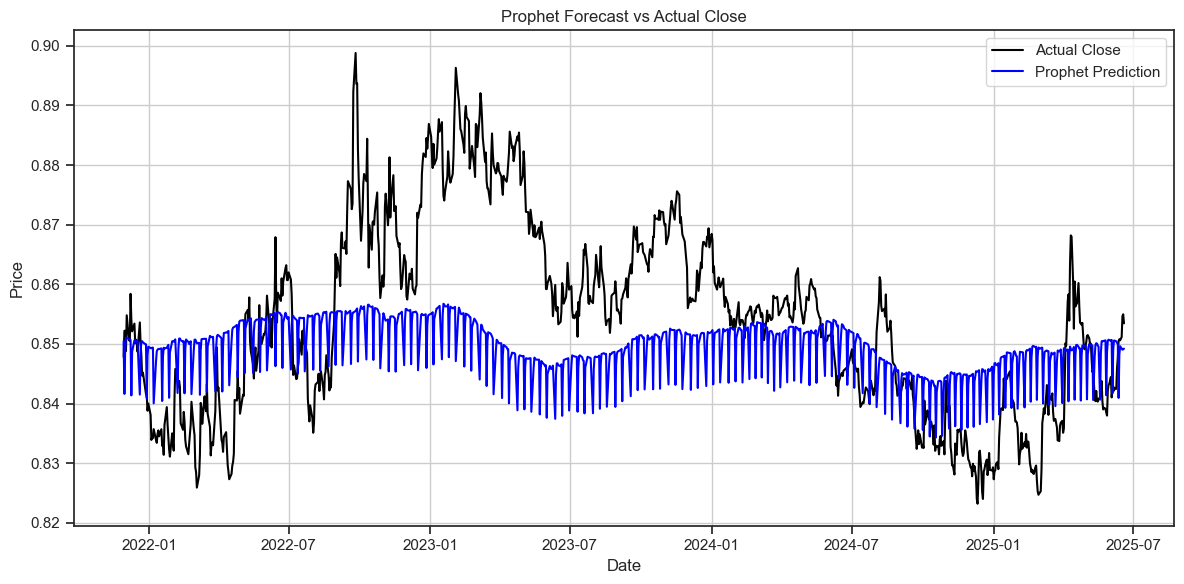

In [1333]:
# === Plot Prophet Forecast vs Actual Close Prices ===

plt.figure(figsize=(12, 6))

# Plot actual close prices
plt.plot(prophet_df['Date'], prophet_df['Actual_Close'], label='Actual Close', color='black')

# Plot predicted close prices from Prophet
plt.plot(prophet_df['Date'], prophet_df['Prophet_Predicted'], label='Prophet Prediction', color='blue')

plt.title('Prophet Forecast vs Actual Close')  # Chart title
plt.xlabel('Date')                             # X-axis label
plt.ylabel('Price')                            # Y-axis label
plt.legend()                                   # Display legend
plt.grid(True)                                 # Add grid for readability
plt.tight_layout()                             # Optimize layout
plt.show()                                     # Render the plot

In [1334]:
evaluate_model("Prophet", actual, prophet_preds)

Prophet Evaluation:
MAE:  0.0125
RMSE: 0.0155
R²:   0.0489



In [1335]:
# ARIMA

In [1336]:
# === ARIMA Forecasting ===
from pmdarima import auto_arima

# === Prepare target and exogenous ===
y_arima_train = df_train['Close'].iloc[:-len(X_test)]
X_arima_train = X_train
X_arima_test = X_test
test_dates = df_train['Date'].iloc[-len(X_arima_test):].values

In [1337]:
arima_model = auto_arima(
    y=y_arima_train,
    exogenous=X_arima_train,
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    seasonal=False,
    d=0,  # no differencing, predict actual values
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

In [1338]:
# Forecast Close using test exogenous features
arima_preds = arima_model.predict(n_periods=len(X_arima_test), exogenous=X_arima_test)
actual_close = df_train['Close'].iloc[-len(X_arima_test):].values

# Create a DataFrame to compare ARIMA predictions with actual close prices for the test period
arima_plot_df = pd.DataFrame({
    'Date': test_dates, # Corresponding dates
    'Actual_Close': actual_close, # Actual close prices
    'ARIMA_Predicted': arima_preds # Predicted close prices from ARIMA
})

In [1339]:
evaluate_model("ARIMA (Auto)", actual_close, arima_preds)

ARIMA (Auto) Evaluation:
MAE:  0.0254
RMSE: 0.0295
R²:   -2.4377



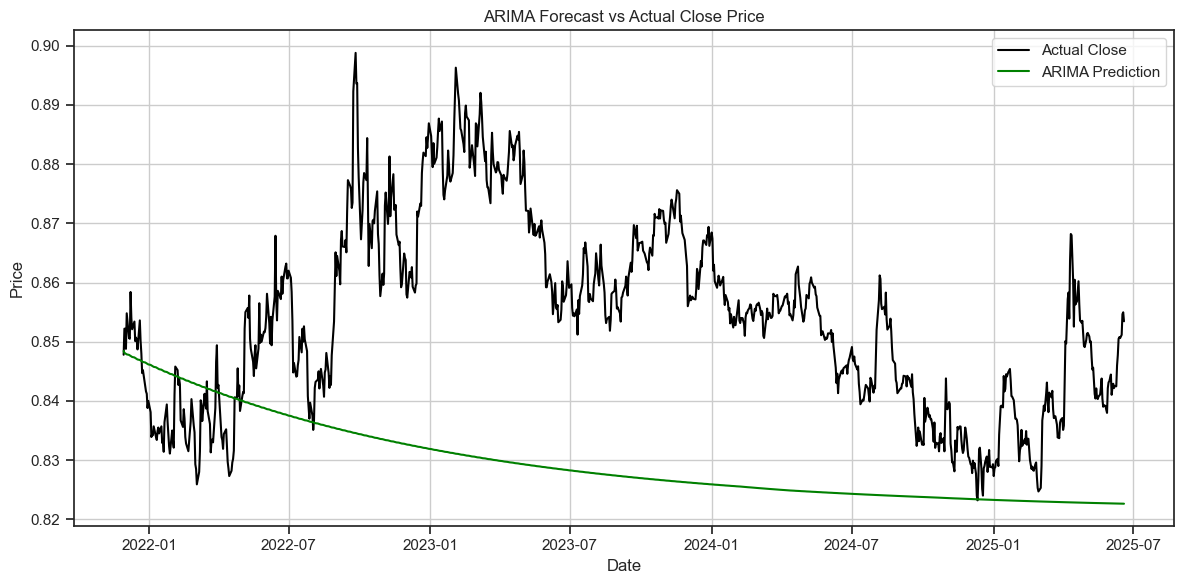

In [1340]:
# === Plot ARIMA Forecast vs Actual Close Prices ===

plt.figure(figsize=(12, 6))

# Plot actual close prices
plt.plot(arima_plot_df['Date'], arima_plot_df['Actual_Close'], label='Actual Close', color='black')

# Plot ARIMA predicted close prices
plt.plot(arima_plot_df['Date'], arima_plot_df['ARIMA_Predicted'], label='ARIMA Prediction', color='green')

plt.title('ARIMA Forecast vs Actual Close Price')  # Title of the plot
plt.xlabel('Date')                                 # Label for the x-axis
plt.ylabel('Price')                                # Label for the y-axis
plt.legend()                                       # Show legend to distinguish lines
plt.grid(True)                                     # Add gridlines for better readability
plt.tight_layout()                                 # Adjust layout to fit elements neatly
plt.show()                                         # Display the plot

In [1341]:
# LSTM

In [1342]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [1343]:
def reshape_for_lstm(X, y, timesteps=10):
    X_lstm, y_lstm = [], []
    y = np.array(y)  
    for i in range(timesteps, len(X)):
        X_lstm.append(X[i - timesteps:i])
        y_lstm.append(y[i])
    return np.array(X_lstm), np.array(y_lstm)

In [1344]:
# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1345]:
# Reshape for LSTM input
X_lstm_train, y_lstm_train = reshape_for_lstm(X_train_scaled, y_train, timesteps=10)
X_lstm_test, y_lstm_test = reshape_for_lstm(X_test_scaled, y_test, timesteps=10)

In [1346]:
# LSTM Model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(1))

In [1347]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
model.fit(X_lstm_train, y_lstm_train, epochs=30, batch_size=32, verbose=0)

# Predict
lstm_preds = model.predict(X_lstm_test).flatten()

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


In [1348]:
evaluate_model("LSTM", y_lstm_test, lstm_preds)

LSTM Evaluation:
MAE:  0.0045
RMSE: 0.0057
R²:   0.8726



In [1349]:
# Create a DataFrame for plotting
lstm_plot_df = pd.DataFrame({
    'Date': df_train['Date'].iloc[-len(y_lstm_test):].values,
    'Actual_Close': y_lstm_test,
    'LSTM_Predicted': lstm_preds
})

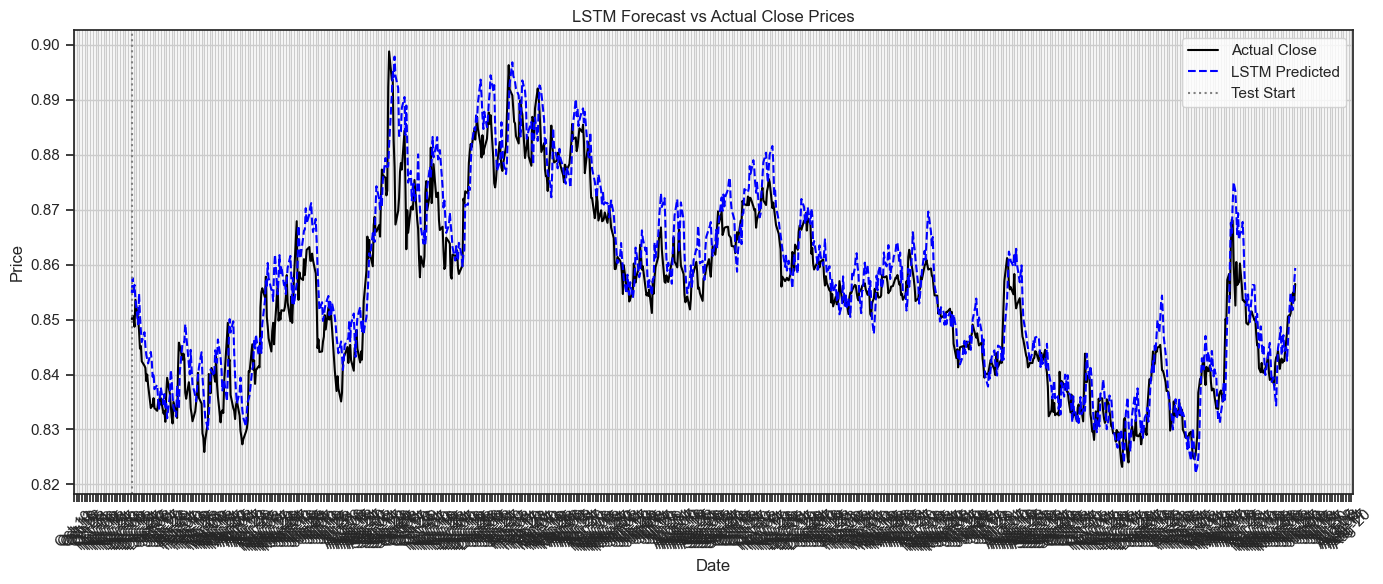

In [1350]:
# Plot actual vs. predicted
plt.figure(figsize=(14, 6))
plt.plot(lstm_plot_df['Date'], lstm_plot_df['Actual_Close'], label='Actual Close', color='black')
plt.plot(lstm_plot_df['Date'], lstm_plot_df['LSTM_Predicted'], label='LSTM Predicted', color='blue', linestyle='--')

plt.axvline(x=lstm_plot_df['Date'].iloc[0], color='gray', linestyle=':', label='Test Start')

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)

plt.title("LSTM Forecast vs Actual Close Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1351]:
# XGBOOST

In [1352]:
# === XGBoost Regression Model ===

from xgboost import XGBRegressor

# Initialize XGBoost regressor with 100 trees and learning rate of 0.1
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)

# Train the model on the training data
xgb.fit(X_train, y_train)

# Predict the target variable on the test data
xgb_preds = xgb.predict(X_test)

In [1353]:
# Create a DataFrame with actual, LSTM, and XGBoost predictions
compare_df = pd.DataFrame({
    'Date': df_train['Date'].iloc[-len(y_lstm_test):].values,
    'Actual_Close': y_lstm_test,
    'LSTM_Predicted': lstm_preds,
    'XGBoost_Predicted': xgb_preds[-len(y_lstm_test):]  # match LSTM window
})

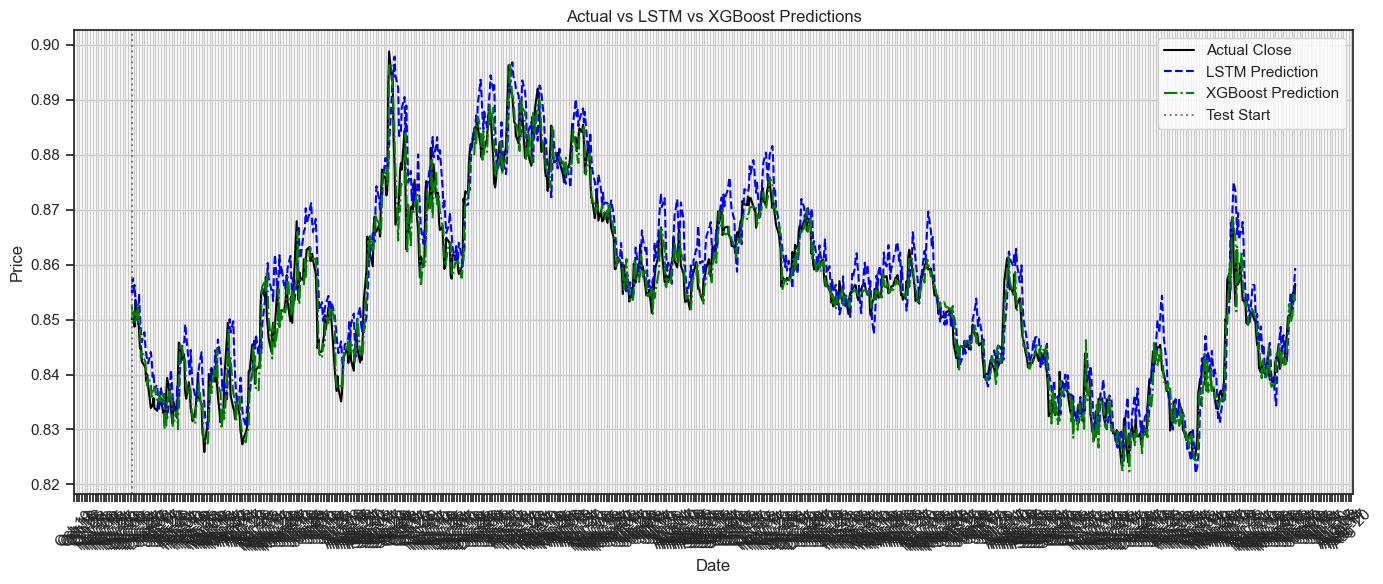

In [1354]:
# Plot
plt.figure(figsize=(14, 6))
plt.plot(compare_df['Date'], compare_df['Actual_Close'], label='Actual Close', color='black')
plt.plot(compare_df['Date'], compare_df['LSTM_Predicted'], label='LSTM Prediction', color='blue', linestyle='--')
plt.plot(compare_df['Date'], compare_df['XGBoost_Predicted'], label='XGBoost Prediction', color='green', linestyle='-.')

plt.axvline(x=compare_df['Date'].iloc[0], color='gray', linestyle=':', label='Test Start')

# X-axis formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)

plt.title("Actual vs LSTM vs XGBoost Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1355]:
# Ensure all prediction arrays from Prophet, ARIMA, and XGBoost have the same length for proper comparison
assert len(prophet_preds) == len(xgb_preds)

In [1356]:
# Ensemble models

In [1357]:
# === Average Ensemble Prediction ===
# Combine predictions from Prophet, LSTM, and XGBoost by averaging them
# Determine the forecast length based on LSTM (shortest due to time steps)
forecast_len = len(lstm_preds)

# Trim Prophet and XGBoost predictions to match LSTM length
trimmed_prophet = prophet_preds[-forecast_len:]
trimmed_xgb = xgb_preds[-forecast_len:]

# === Average Ensemble Prediction ===
ensemble_preds = (trimmed_prophet + lstm_preds + trimmed_xgb) / 3


In [1358]:
# === Weighted Ensemble Prediction ===

# Find the minimum prediction length across all models
min_len = min(len(prophet_preds), len(lstm_preds), len(xgb_preds))

# Trim all predictions to the same length
prophet_trimmed = prophet_preds[-min_len:]
lstm_trimmed = lstm_preds[-min_len:]
xgb_trimmed = xgb_preds[-min_len:]
y_test_trimmed = y_test[-min_len:]

# Weighted average: give XGBoost stronger influence
weighted_preds = (
    0.1 * prophet_trimmed +
    0.1 * lstm_trimmed +
    0.8 * xgb_trimmed
)

# Evaluate the weighted ensemble
evaluate_model("Weighted Ensemble", y_test_trimmed, weighted_preds)

Weighted Ensemble Evaluation:
MAE:  0.0025
RMSE: 0.0033
R²:   0.9562



In [1359]:
# === Create Ensemble Comparison DataFrame ===

# Construct a DataFrame to compare actual close prices with all model predictions
# Align everything to min_len
ensemble_df = pd.DataFrame({
    'Date': df_train['Date'].iloc[-min_len:].values,
    'Actual_Close': df_train['Close'].iloc[-min_len:].values,
    'Prophet': prophet_preds[-min_len:],
    'ARIMA': arima_preds[-min_len:],
    'LSTM': lstm_preds[-min_len:],
    'XGBoost': xgb_preds[-min_len:],
    'Ensemble': ensemble_preds[-min_len:],
    'Weighted Ensemble': weighted_preds[-min_len:]
})


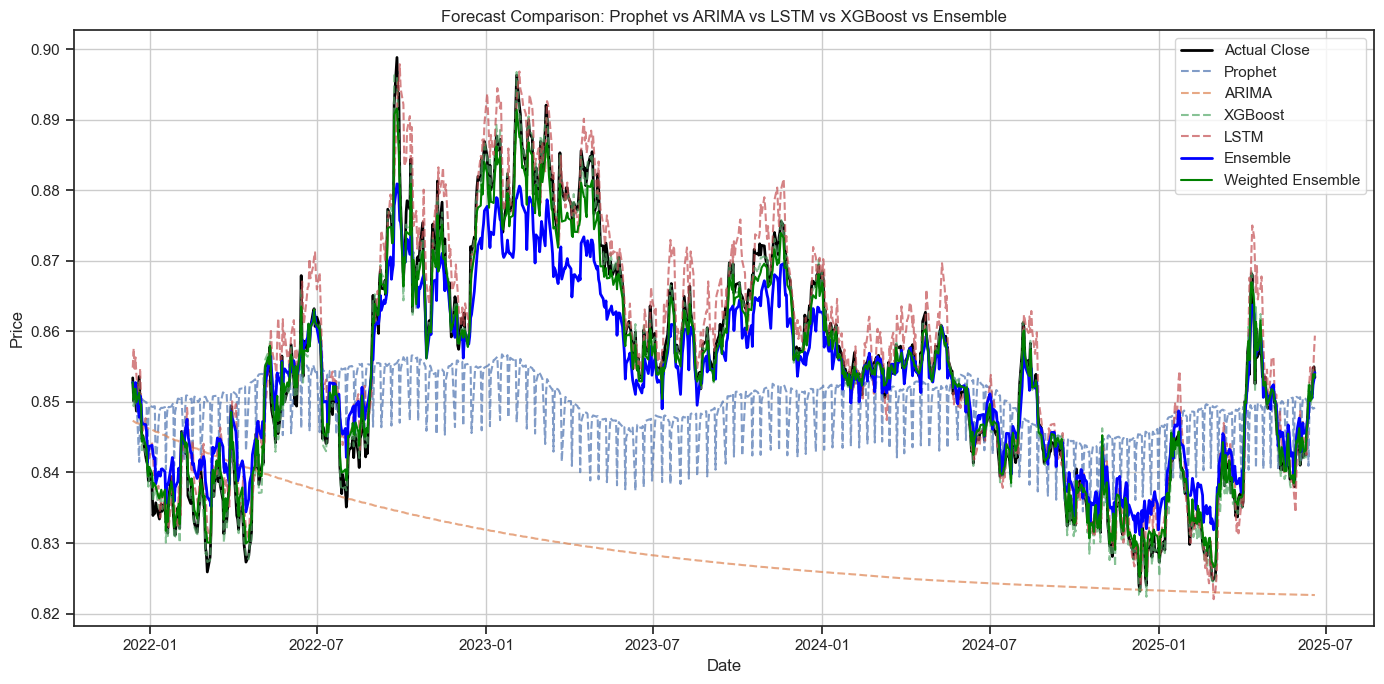

In [1360]:
# === Plot Forecast Comparison ===

plt.figure(figsize=(14, 7))

# Plot actual close prices
plt.plot(ensemble_df['Date'], ensemble_df['Actual_Close'], label='Actual Close', color='black', linewidth=2)

# Plot individual model predictions
plt.plot(ensemble_df['Date'], ensemble_df['Prophet'], label='Prophet', linestyle='--', alpha=0.7)
plt.plot(ensemble_df['Date'], ensemble_df['ARIMA'], label='ARIMA', linestyle='--', alpha=0.7)
plt.plot(ensemble_df['Date'], ensemble_df['XGBoost'], label='XGBoost', linestyle='--', alpha=0.7)
plt.plot(ensemble_df['Date'], ensemble_df['LSTM'], label='LSTM', linestyle='--', alpha=0.7)

# Plot ensemble predictions
plt.plot(ensemble_df['Date'], ensemble_df['Ensemble'], label='Ensemble', color='blue', linewidth=2)
plt.plot(ensemble_df['Date'], ensemble_df['Weighted Ensemble'], label='Weighted Ensemble', linestyle='-', color='green')

# Final plot formatting
plt.title('Forecast Comparison: Prophet vs ARIMA vs LSTM vs XGBoost vs Ensemble')  # Title
plt.xlabel('Date')     # X-axis label
plt.ylabel('Price')    # Y-axis label
plt.legend()           # Legend to identify lines
plt.grid(True)         # Add gridlines
plt.tight_layout()     # Adjust layout for clarity
plt.show()             # Display the plot

In [1361]:
# Metrics evaluation

In [1362]:
# Import regression evaluation metrics from scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [1363]:
# === Evaluate All Models ===

# Now safely evaluate models
evaluate_model("Prophet", y_test_trimmed, prophet_preds[-min_len:])
evaluate_model("ARIMA", y_test_trimmed, arima_preds[-min_len:])
evaluate_model("XGBoost", y_test_trimmed, xgb_preds[-min_len:])
evaluate_model("LSTM", y_test_trimmed, lstm_preds[-min_len:])
evaluate_model("Ensemble", y_test_trimmed, ensemble_preds[-min_len:])
evaluate_model("Weighted Ensemble", y_test_trimmed, weighted_preds[-min_len:])


Prophet Evaluation:
MAE:  0.0125
RMSE: 0.0155
R²:   0.0563

ARIMA Evaluation:
MAE:  0.0256
RMSE: 0.0296
R²:   -2.4386

XGBoost Evaluation:
MAE:  0.0023
RMSE: 0.0032
R²:   0.9603

LSTM Evaluation:
MAE:  0.0045
RMSE: 0.0057
R²:   0.8726

Ensemble Evaluation:
MAE:  0.0045
RMSE: 0.0057
R²:   0.8725

Weighted Ensemble Evaluation:
MAE:  0.0025
RMSE: 0.0033
R²:   0.9562



In [1364]:
# Stacking Ensembling

In [1365]:
# === Prepare Data for Stacking (Level 0) ===

# Trim all to match min_len
stack_X_train = np.vstack([
    prophet_preds[-min_len:],    # Column 1: Prophet
    arima_preds[-min_len:],      # Column 2: ARIMA
    xgb_preds[-min_len:],        # Column 3: XGBoost
    lstm_preds[-min_len:]        # Column 4: LSTM
]).T  # Transpose to (n_samples, n_models)

# Align the target values
stack_y_train = y_test_trimmed.values

In [1366]:
# Initialize dictionary to store evaluation metrics
meta_model_scores = {}

In [1367]:
# === LassoCV Meta-Model ===
from sklearn.linear_model import LassoCV

# Initialize and train Lasso with cross-validated alpha
lasso_meta = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5)
lasso_meta.fit(stack_X_train, stack_y_train)

# Generate predictions
lasso_preds = lasso_meta.predict(stack_X_train)
trimmed_y_test = y_test[-len(lasso_preds):].values

# Evaluate and display performance
evaluate_model("LassoCV Meta", trimmed_y_test, lasso_preds)

# Store metrics in dictionary
meta_model_scores['LassoCV'] = {
    'RMSE': np.sqrt(mean_squared_error(trimmed_y_test, lasso_preds)),
    'MAE': mean_absolute_error(trimmed_y_test, lasso_preds),
    'R2': r2_score(trimmed_y_test, lasso_preds)
}

LassoCV Meta Evaluation:
MAE:  0.0057
RMSE: 0.0070
R²:   0.8076



In [1368]:
assert len(y_test_trimmed) == len(trimmed_y_test)

In [1369]:
# === Random Forest Meta-Model ===
from sklearn.ensemble import RandomForestRegressor

# Initialize and train Random Forest
rf_meta = RandomForestRegressor(n_estimators=100, random_state=42)
rf_meta.fit(stack_X_train, stack_y_train)

# Generate predictions
rf_preds = rf_meta.predict(stack_X_train)

# Evaluate and display performance
evaluate_model("Random Forest Meta", trimmed_y_test, rf_preds)

# Store metrics in dictionary
meta_model_scores['RandomForest'] = {
    'RMSE': np.sqrt(mean_squared_error(trimmed_y_test, rf_preds)),
    'MAE': mean_absolute_error(trimmed_y_test, rf_preds),
    'R2': r2_score(trimmed_y_test, rf_preds)
}

Random Forest Meta Evaluation:
MAE:  0.0009
RMSE: 0.0013
R²:   0.9938



In [1370]:
# === Gradient Boosting Meta-Model ===
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and train Gradient Boosting Regressor
gb_meta = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05)
gb_meta.fit(stack_X_train, stack_y_train)

# Generate predictions
gb_preds = gb_meta.predict(stack_X_train)

# Evaluate and display performance
evaluate_model("Gradient Boosting Meta", trimmed_y_test, gb_preds)

# Store metrics in dictionary
meta_model_scores['GradientBoosting'] = {
    'RMSE': np.sqrt(mean_squared_error(trimmed_y_test, gb_preds)),
    'MAE': mean_absolute_error(trimmed_y_test, gb_preds),
    'R2': r2_score(trimmed_y_test, gb_preds)
}

Gradient Boosting Meta Evaluation:
MAE:  0.0019
RMSE: 0.0026
R²:   0.9736



In [1371]:
# === Ridge Regression as Meta-Model ===

from sklearn.linear_model import RidgeCV

# Initialize RidgeCV with cross-validation over a range of alpha values
ridge_meta = RidgeCV(alphas=np.logspace(-3, 2, 10), cv=5)

# Fit the model using Level 0 predictions (stacked inputs)
ridge_meta.fit(stack_X_train, stack_y_train)

# Predict using the trained Ridge meta-model
ridge_preds = ridge_meta.predict(stack_X_train)

# Evaluate the RidgeCV meta-model's performance
evaluate_model("RidgeCV Meta", trimmed_y_test, ridge_preds)

meta_model_scores['RidgeCV'] = {
    'RMSE': np.sqrt(mean_squared_error(trimmed_y_test, gb_preds)),
    'MAE': mean_absolute_error(trimmed_y_test, gb_preds),
    'R2': r2_score(trimmed_y_test, gb_preds)
}

RidgeCV Meta Evaluation:
MAE:  0.0023
RMSE: 0.0031
R²:   0.9616



In [1372]:
# === Use Best Meta-Model from Dictionary ===

# Find the model name with the lowest RMSE
best_model_name = min(meta_model_scores, key=lambda k: meta_model_scores[k]['RMSE'])

print(f" Best Meta-Model based on RMSE: {best_model_name}")

# Initialize and fit the best model
if best_model_name == 'RidgeCV':
    from sklearn.linear_model import RidgeCV
    meta_model = RidgeCV(alphas=np.logspace(-3, 2, 10), cv=5)
elif best_model_name == 'LassoCV':
    from sklearn.linear_model import LassoCV
    meta_model = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5)
elif best_model_name == 'RandomForest':
    from sklearn.ensemble import RandomForestRegressor
    meta_model = RandomForestRegressor(n_estimators=100, random_state=42)
elif best_model_name == 'GradientBoosting':
    from sklearn.ensemble import GradientBoostingRegressor
    meta_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05)
else:
    raise ValueError(f"Unknown model: {best_model_name}")

# Fit the best meta-model
meta_model.fit(stack_X_train, stack_y_train)

# Generate final stacked predictions
stacked_preds = meta_model.predict(stack_X_train)


 Best Meta-Model based on RMSE: RandomForest


In [1373]:
# Evaluate the performance of the stacked ensemble model against actual test values
evaluate_model("Stacked Ensemble", trimmed_y_test, stacked_preds)

Stacked Ensemble Evaluation:
MAE:  0.0009
RMSE: 0.0013
R²:   0.9938



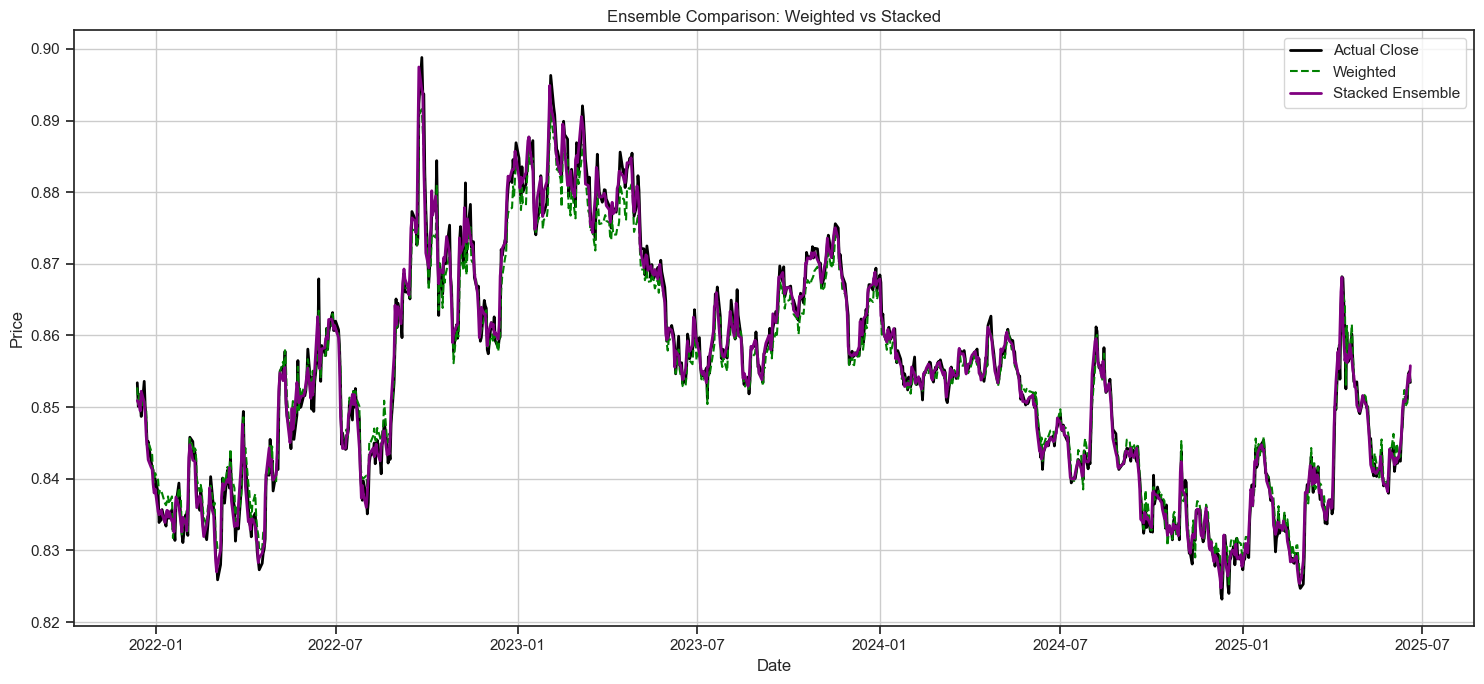

In [1374]:
# === Plot: Weighted vs Stacked Ensemble ===

# Add stacked ensemble predictions to the comparison DataFrame
ensemble_df['Stacked Ensemble'] = stacked_preds

plt.figure(figsize=(15, 7))

# Plot actual close prices
plt.plot(ensemble_df['Date'], ensemble_df['Actual_Close'], label='Actual Close', color='black', linewidth=2)

# Plot weighted ensemble predictions
plt.plot(ensemble_df['Date'], ensemble_df['Weighted Ensemble'], label='Weighted', linestyle='--', color='green')

# Plot stacked ensemble predictions
plt.plot(ensemble_df['Date'], ensemble_df['Stacked Ensemble'], label='Stacked Ensemble', color='purple', linewidth=2)

# Final plot formatting
plt.title('Ensemble Comparison: Weighted vs Stacked')  # Chart title
plt.xlabel('Date')                                     # X-axis label
plt.ylabel('Price')                                    # Y-axis label
plt.legend()                                           # Display legend
plt.grid(True)                                         # Add grid
plt.tight_layout()                                     # Adjust layout
plt.show()                                             # Display the plot

In [1375]:
# CROSS VAL FOR META AND CHECK FOR OVERFITTING

In [1376]:
from sklearn.model_selection import cross_val_score, KFold

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [1377]:
# Use negative RMSE and MAE for scoring
cv_rmse = -cross_val_score(rf_meta, stack_X_train, stack_y_train, cv=cv, scoring='neg_root_mean_squared_error')
cv_mae = -cross_val_score(rf_meta, stack_X_train, stack_y_train, cv=cv, scoring='neg_mean_absolute_error')
cv_r2 = cross_val_score(rf_meta, stack_X_train, stack_y_train, cv=cv, scoring='r2')

# Average predictions for direct comparison
rf_meta.fit(stack_X_train, stack_y_train)
rf_preds = rf_meta.predict(stack_X_train)

# Display cross-val metrics
print("📊 Random Forest Meta Cross-Validation:")
print(f"  ▸ CV RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
print(f"  ▸ CV MAE : {cv_mae.mean():.4f} ± {cv_mae.std():.4f}")
print(f"  ▸ CV R²  : {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
print()

# Final evaluation on hold-out set
evaluate_model("Random Forest Meta (Hold-out)", trimmed_y_test, rf_preds)

# Store cross-val scores
meta_model_scores['RandomForest_CV'] = {
    'CV_RMSE': cv_rmse.mean(),
    'CV_MAE': cv_mae.mean(),
    'CV_R2': cv_r2.mean()
}


📊 Random Forest Meta Cross-Validation:
  ▸ CV RMSE: 0.0033 ± 0.0002
  ▸ CV MAE : 0.0025 ± 0.0001
  ▸ CV R²  : 0.9555 ± 0.0069

Random Forest Meta (Hold-out) Evaluation:
MAE:  0.0009
RMSE: 0.0013
R²:   0.9938



In [1378]:
rf_meta.fit(X_train, y_train)

# 2. Predict on train and test
y_train_pred = rf_meta.predict(X_train)
y_test_pred = rf_meta.predict(X_test)

# Trim all arrays to same length
y_train_trim = y_train[-min_len:]
y_train_pred_trim = y_train_pred[-min_len:]
y_test_trim = y_test[-min_len:]
y_test_pred_trim = y_test_pred[-min_len:]

# Evaluation
print("📊 Train Performance (Trimmed):")
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("R² Score:", r2_score(y_train, y_train_pred))

print("\n📊 Test Performance (Trimmed):")
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("R² Score:", r2_score(y_test, y_test_pred))

📊 Train Performance (Trimmed):
MAE: 0.0012662128916281494
RMSE: 0.0017550176481450094
R² Score: 0.9992392497596838

📊 Test Performance (Trimmed):
MAE: 0.002393618069815204
RMSE: 0.003252046541236083
R² Score: 0.9581273476180932


In [1379]:
predicted = y_test_pred
expected = y_test
gap = []
for p, e in zip(predicted, expected):
#    print(f'predicted: {p:.5f}, expected: {e}')
    gap.append(e - float(p))

In [1380]:
print(max(gap))
print((min(gap) ** 2)**0.5)

0.020690999999999904
0.011926999999999466


In [1381]:
import os
import joblib

# Ensure models directory exists
os.makedirs("models", exist_ok=True)

# === Base Models ===
# XGBoost
xgb.save_model("models/xgb_model.json")

# ARIMA
joblib.dump(arima_model, "models/arima_model.pkl")

# Prophet
joblib.dump(prophet, "models/prophet_model.pkl")

# === Meta-Models ===
joblib.dump(meta_model, "models/meta_model_ridge.pkl")
joblib.dump(lasso_meta, "models/meta_model_lasso.pkl")
joblib.dump(rf_meta, "models/meta_model_rf.pkl")
joblib.dump(gb_meta, "models/meta_model_gb.pkl")

# === Ensemble Results ===
joblib.dump(ensemble_df, "models/ensemble_results_df.pkl")

# Optional: Save feature sets
joblib.dump((X_train, X_test, y_train, y_test), "models/data_split.pkl")

['models/data_split.pkl']

In [1382]:
# Predicting Future Outcome

In [1383]:
df_last_2weeks_x = df_last_2weeks.drop(columns=['Date', 'target_regression', 'target_classification'])
vv = 'target_regression'

In [1384]:
df_last_2weeks.shape

(12, 47)

In [1385]:
predicted = rf_meta.predict(df_last_2weeks_x)
expected = df_last_2weeks[vv].values
gap = []
for p, e in zip(predicted, expected):
    print(f'predicted: {p:.5f}, expected: {e}')
    gap.append(e - float(p))

predicted: 0.85440, expected: 0.85658
predicted: 0.85408, expected: 0.85582
predicted: 0.85293, expected: 0.85244
predicted: 0.85116, expected: 0.85292
predicted: 0.85233, expected: 0.85177
predicted: 0.85172, expected: 0.8537
predicted: 0.85320, expected: 0.85424
predicted: 0.85338, expected: 0.85803
predicted: 0.85756, expected: 0.8586
predicted: 0.85758, expected: 0.86516
predicted: 0.86393, expected: 0.86091
predicted: 0.86125, expected: 0.86344


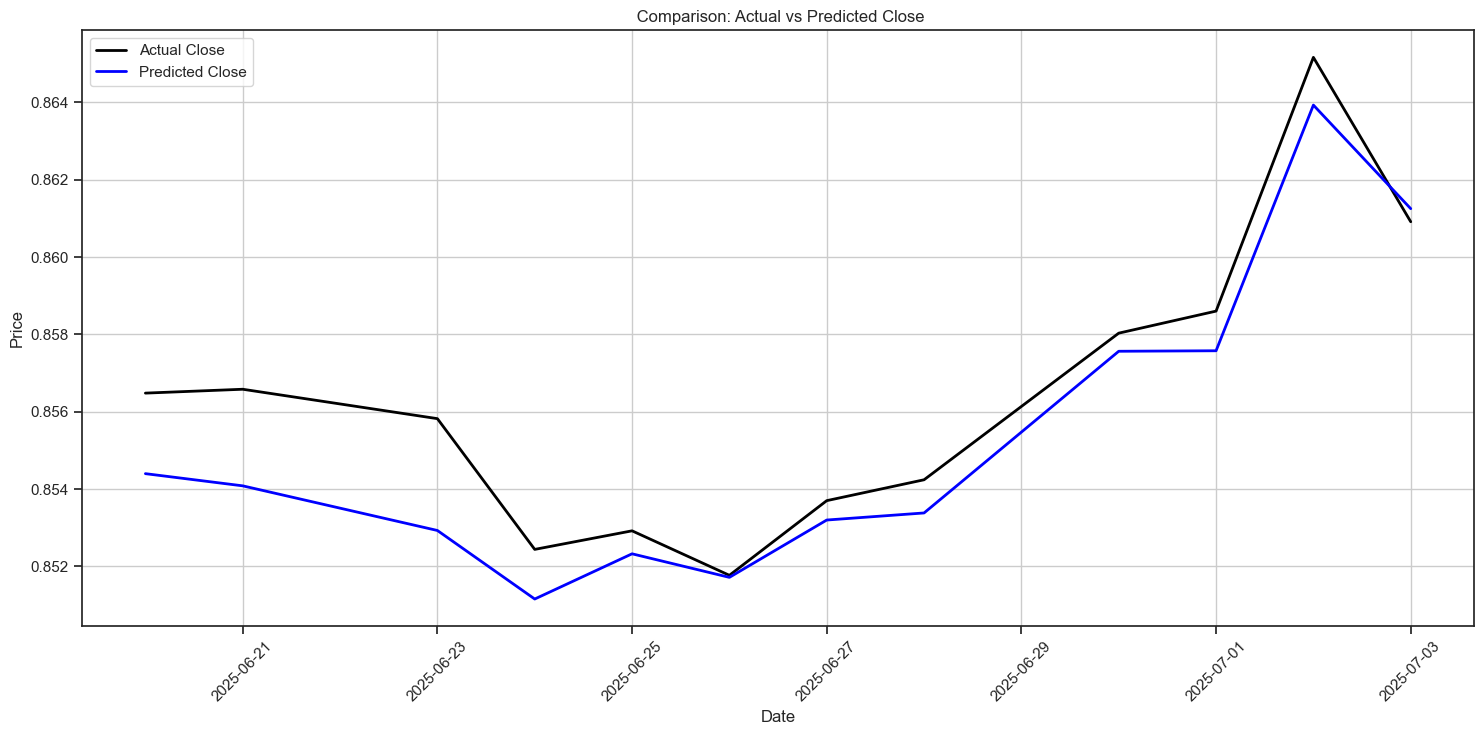

In [1386]:
# Plot
plt.figure(figsize=(15, 7))

# Actual Close Prices
plt.plot(df_last_2weeks['Date'], df_last_2weeks['Close'], label='Actual Close', color='black', linewidth=2)

# Random Forest Predictions
plt.plot(df_last_2weeks['Date'], predicted, label='Predicted Close', color='blue', linewidth=2)

# Final plot formatting
plt.title(' Comparison: Actual vs Predicted Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

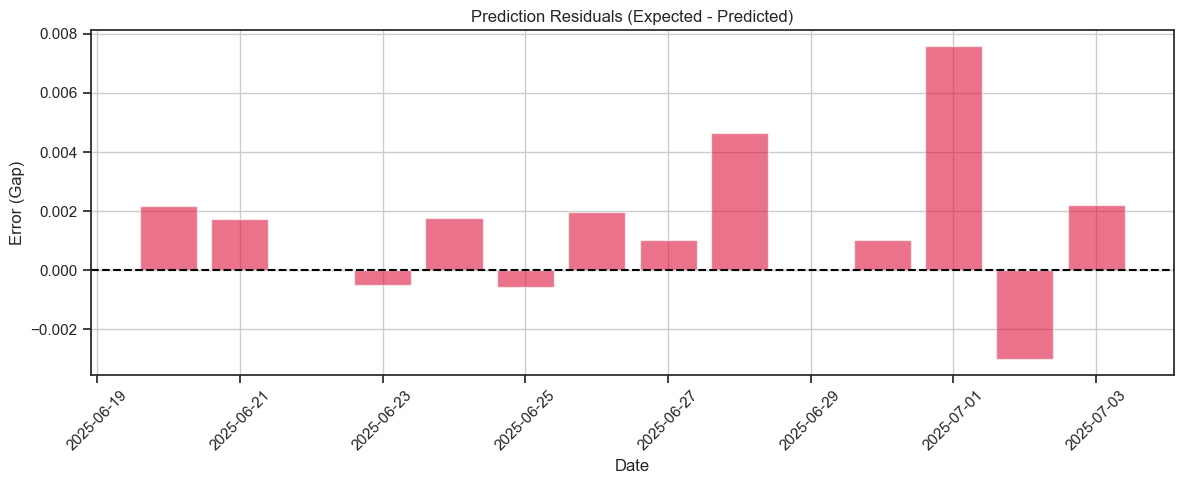

In [1387]:
# Compute residuals (gap)
gap = [e - float(p) for p, e in zip(predicted, expected)]

# Optional: use dates from df if aligned
labels = df_last_2weeks['Date'][-len(gap):] if 'Date' in df_last_2weeks.columns else range(len(gap))

# Plot
plt.figure(figsize=(12, 5))
bars = plt.bar(labels, gap, color='crimson', alpha=0.6)

plt.axhline(0, color='black', linestyle='--')
plt.title("Prediction Residuals (Expected - Predicted)")
plt.xlabel("Date" if isinstance(labels[0], (str, pd.Timestamp)) else "Sample Index")
plt.ylabel("Error (Gap)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [1388]:
# FORECAST

In [1389]:
# Clone recent history to simulate feature updates
history = df.sort_values("Date").copy().reset_index(drop=True)

# Store predictions
future_preds = []

# Features needed for recomputation
def compute_features(df):
    # Time-based
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['is_week_start'] = (df['dayofweek'] == 0).astype(int)
    df['is_week_end'] = (df['dayofweek'] == 4).astype(int)

    # Returns
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['return_1d'] = df['Close'].pct_change()
    df['log_return_positive'] = (df['Log_Return'] > 0).astype(int)

    # Lag features
    df['lag_1'] = df['Close'].shift(1)
    df['lag_2'] = df['Close'].shift(2)
    df['lag_3'] = df['Close'].shift(3)

    # SMA
    df['Sma_5'] = df['Close'].rolling(window=5).mean()
    df['Sma_21'] = df['Close'].rolling(window=21).mean()
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_100'] = df['Close'].rolling(window=100).mean()

    # Volatility
    df['volatility_10'] = df['Log_Return'].rolling(window=10).std()
    df['volatility_21'] = df['Log_Return'].rolling(window=21).std()

    # RSI
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    ema_fast = df['Close'].ewm(span=12, adjust=False).mean()
    ema_slow = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_fast - ema_slow
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_diff'] = df['MACD'] - df['MACD_signal']

    # Bollinger Bands
    sma_20 = df['Close'].rolling(window=20).mean()
    std_20 = df['Close'].rolling(window=20).std()
    df['BB_upper'] = sma_20 + 2 * std_20
    df['BB_lower'] = sma_20 - 2 * std_20
    df['BB_width'] = df['BB_upper'] - df['BB_lower']

    # ATR
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=14).mean()

    # Candle features
    df['upper_shadow'] = df['High'] - df[['Open', 'Close']].max(axis=1)
    df['lower_shadow'] = df[['Open', 'Close']].min(axis=1) - df['Low']
    df['body'] = abs(df['Close'] - df['Open'])
    df['range'] = df['High'] - df['Low']
    df['is_doji'] = (df['body'] / df['range'] < 0.1).astype(int)
    df['is_hammer'] = ((df['lower_shadow'] > 2 * df['body']) & (df['upper_shadow'] < df['body'])).astype(int)
    df['is_inverted_hammer'] = ((df['upper_shadow'] > 2 * df['body']) & (df['lower_shadow'] < df['body'])).astype(int)

    df['is_bullish_engulfing'] = ((df['Close'].shift(1) < df['Open'].shift(1)) &
                                  (df['Close'] > df['Open']) &
                                  (df['Open'] < df['Close'].shift(1)) &
                                  (df['Close'] > df['Open'].shift(1))).astype(int)

    df['is_bearish_engulfing'] = ((df['Close'].shift(1) > df['Open'].shift(1)) &
                                   (df['Close'] < df['Open']) &
                                   (df['Open'] > df['Close'].shift(1)) &
                                   (df['Close'] < df['Open'].shift(1))).astype(int)

    # Binary helpers
    df['price_above_sma20'] = (df['Close'] > df['SMA_20']).astype(int)
    df['price_above_sma50'] = (df['Close'] > df['SMA_50']).astype(int)
    df['sma_crossover'] = (df['sma_5'] > df['sma_10']).astype(int)

    return df


In [1390]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

In [1391]:
def compute_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line, macd - signal_line

In [1392]:
def compute_bbands(series, period=20, num_std=2):
    sma = series.rolling(window=period).mean()
    std = series.rolling(window=period).std()
    upper = sma + num_std * std
    lower = sma - num_std * std
    width = upper - lower
    return upper, lower, width


In [1399]:
import numpy as np

# Clone recent history
history = df.sort_values("Date").copy().reset_index(drop=True)
future_preds = []

for i in range(10):
    next_date = history.iloc[-1]['Date'] + pd.Timedelta(days=1)
    last_row = history.iloc[-1]

    # Estimate a small volatility factor (1% of price)
    atr = history.iloc[-2]['ATR'] if 'ATR' in history.columns else last_row['Close'] * 0.01
    high_noise = np.random.uniform(0.3, 1.0) * atr
    low_noise = np.random.uniform(0.3, 1.0) * atr

    # Create simulated new row
    new_row = {
        'Date': next_date,
        'Open': last_row['Close'],
        'Close': history['sma_5'].iloc[-1] if 'sma_5' in history.columns else last_row['Close'],  # will be updated after prediction
        'High': last_row['Close'] + high_noise,
        'Low': last_row['Close'] - low_noise,
        'Volume': last_row['Volume'],  # reuse volume
    }

    # Append and compute features
    history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)
    # Only recompute the last ~100 rows for rolling feature accuracy
    tail_window = 100  # enough to cover max rolling windows
    tail = compute_features(history.tail(tail_window).copy())
    tail.fillna(method='ffill', inplace=True)
    tail.fillna(0, inplace=True)
    # Update tail into history
    history.update(tail)

    # Predict and update
    X_next = history.iloc[[-1]].reindex(columns=features.columns, fill_value=0)
    y_next = rf_meta.predict(X_next)[0]
    history.at[history.index[-1], 'Close'] = y_next

    # Store
    future_preds.append((next_date, y_next))

# Final output
for date, pred in future_preds:
    print(f"📅 {date.date()} → 🔮 Predicted Close: {pred:.5f}")

📅 2025-07-04 → 🔮 Predicted Close: 0.85993
📅 2025-07-05 → 🔮 Predicted Close: 0.85975
📅 2025-07-06 → 🔮 Predicted Close: 0.86020
📅 2025-07-07 → 🔮 Predicted Close: 0.85966
📅 2025-07-08 → 🔮 Predicted Close: 0.85987
📅 2025-07-09 → 🔮 Predicted Close: 0.85919
📅 2025-07-10 → 🔮 Predicted Close: 0.85908
📅 2025-07-11 → 🔮 Predicted Close: 0.85927
📅 2025-07-12 → 🔮 Predicted Close: 0.85925
📅 2025-07-13 → 🔮 Predicted Close: 0.85918


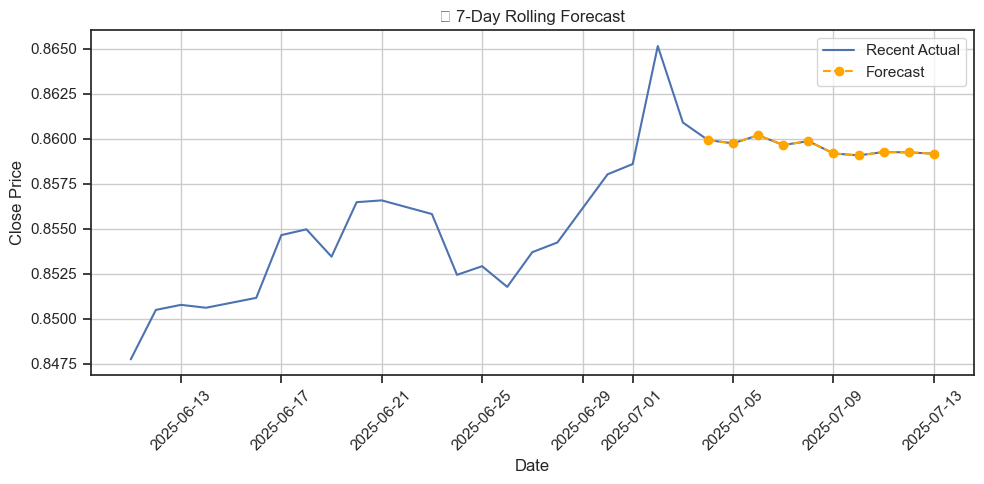

In [1400]:
# Convert to DataFrame
forecast_df = pd.DataFrame(future_preds, columns=["Date", "Predicted_Close"])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(history['Date'][-30:], history['Close'][-30:], label='Recent Actual')
plt.plot(forecast_df['Date'], forecast_df['Predicted_Close'], marker='o', linestyle='--', color='orange', label='Forecast')
plt.title("📉 7-Day Rolling Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1398]:
forecast_df.to_csv("7_day_forecast.csv", index=False)